# ALGORITHM

In [109]:
from LibraryENG import *
name_data = '2019-01-23T11-41-41Pop1 healthy cortical .h5'
complete_string = '../LRRK2_data/Baseline_healthy/'+ name_data

### DATA READING

In [110]:
data = h5py.File(complete_string,'r')
data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency

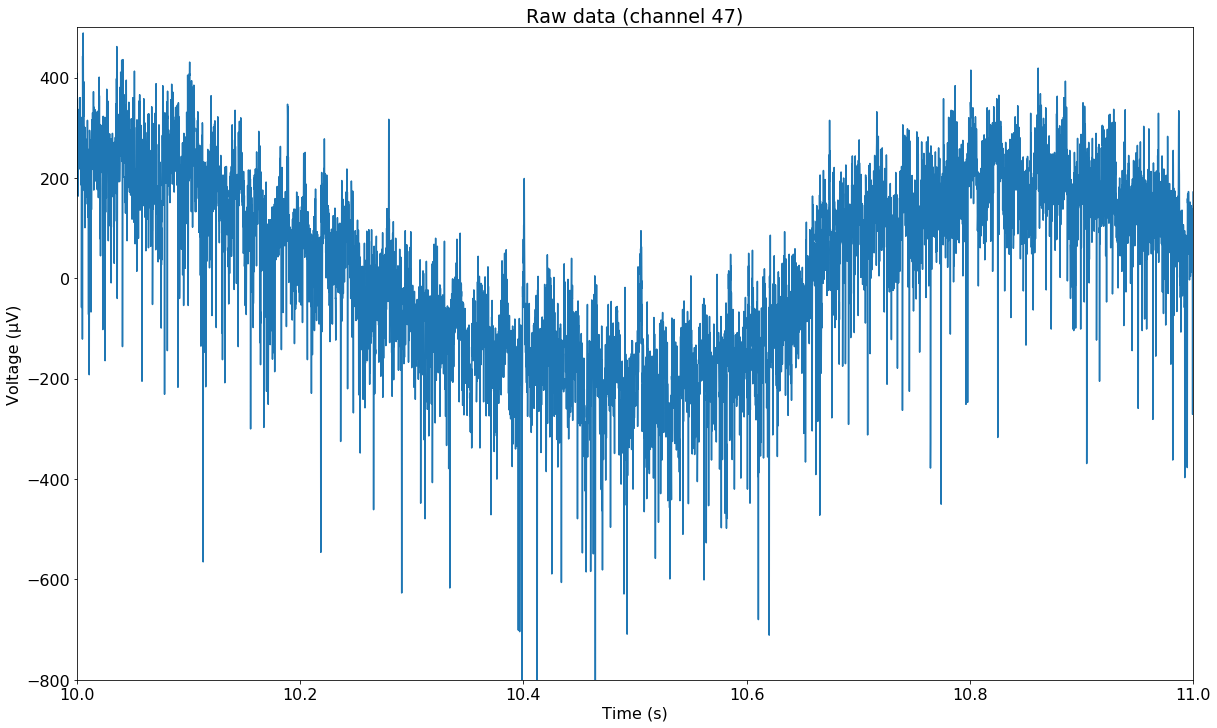

In [111]:
plt.figure(figsize=(20,12))
plt.rcParams.update({'font.size': 16})
plt.plot([x/10000 for x in range (0,readings.shape[0])],readings[b'47'])
plt.axis([10,11,-800,500])
plt.title('Raw data (channel 47)')
plt.ylabel ('Voltage (\u03BCV)')
plt.xlabel('Time (s)')
plt.show()

### PRELIMINAR FILTERING
- We found noises at low frequencies (up to 150Hz). We filtered up to 200Hz to remove the noise.
- We also found weird noises at 453Hz and 906Hz (double its frequency like an harmonic). In this dataset the noise is only present in the Reference Channel, however in other datasets it is present in every channel. We supposed they were due to the acquisition system's impedances. We filtered those frequencies with two notch filters

From now on we used this filtered signal

100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


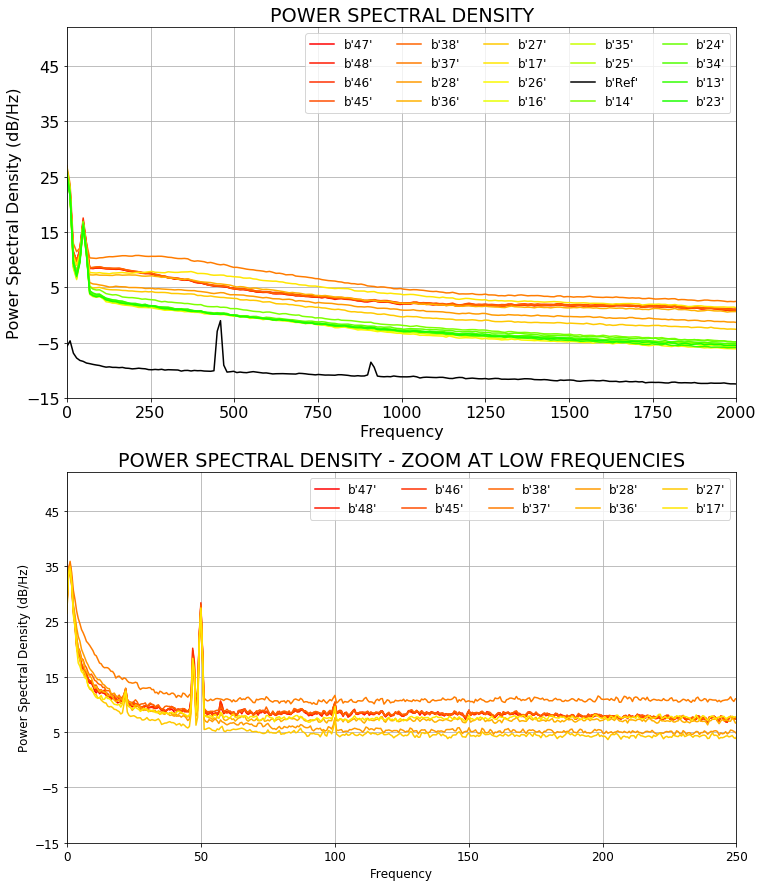

In [112]:
colormap = cm.get_cmap('hsv')
plt.figure(figsize=(12,15))

plt.subplot(2, 1, 1)
plt.rcParams.update({'font.size': 16})
plt.title('POWER SPECTRAL DENSITY')
column = 0
for electrode in tqdm(readings.columns[:20]):
    if electrode == b'Ref':
        plt.psd(readings[electrode],1024 ,Fs=fs,window=np.hamming(1024),noverlap=50, label=electrode, color = "#000000")
    else:
        plt.psd(readings[electrode],1024 ,Fs=fs,window=np.hamming(1024),noverlap=50, label=electrode, color = colormap(np.linspace(0, 1, 60))[column])
    plt.axis([0,2000,-15,52])
    column +=1
plt.rcParams.update({'font.size': 12})
plt.legend(loc='upper right', ncol=5)


plt.subplot(2, 1, 2)
plt.rcParams.update({'font.size': 16})
plt.title('POWER SPECTRAL DENSITY - ZOOM AT LOW FREQUENCIES')
column = 0
for electrode in tqdm(readings.columns[:10]):
    if electrode == b'Ref':
        plt.psd(readings[electrode],1024*16 ,Fs=fs,window=np.hamming(1024*16),noverlap=50, label=electrode, color = "#000000")
    else:
        plt.psd(readings[electrode],1024*16 ,Fs=fs,window=np.hamming(1024*16),noverlap=50, label=electrode, color = colormap(np.linspace(0, 1, 60))[column])
    plt.axis([0,250,-15,52])
    column +=1
plt.rcParams.update({'font.size': 12})
plt.legend(loc='upper right', ncol=5)


plt.show()

100%|██████████| 60/60 [00:12<00:00,  4.91it/s]


458.984375


100%|██████████| 60/60 [00:08<00:00,  6.83it/s]


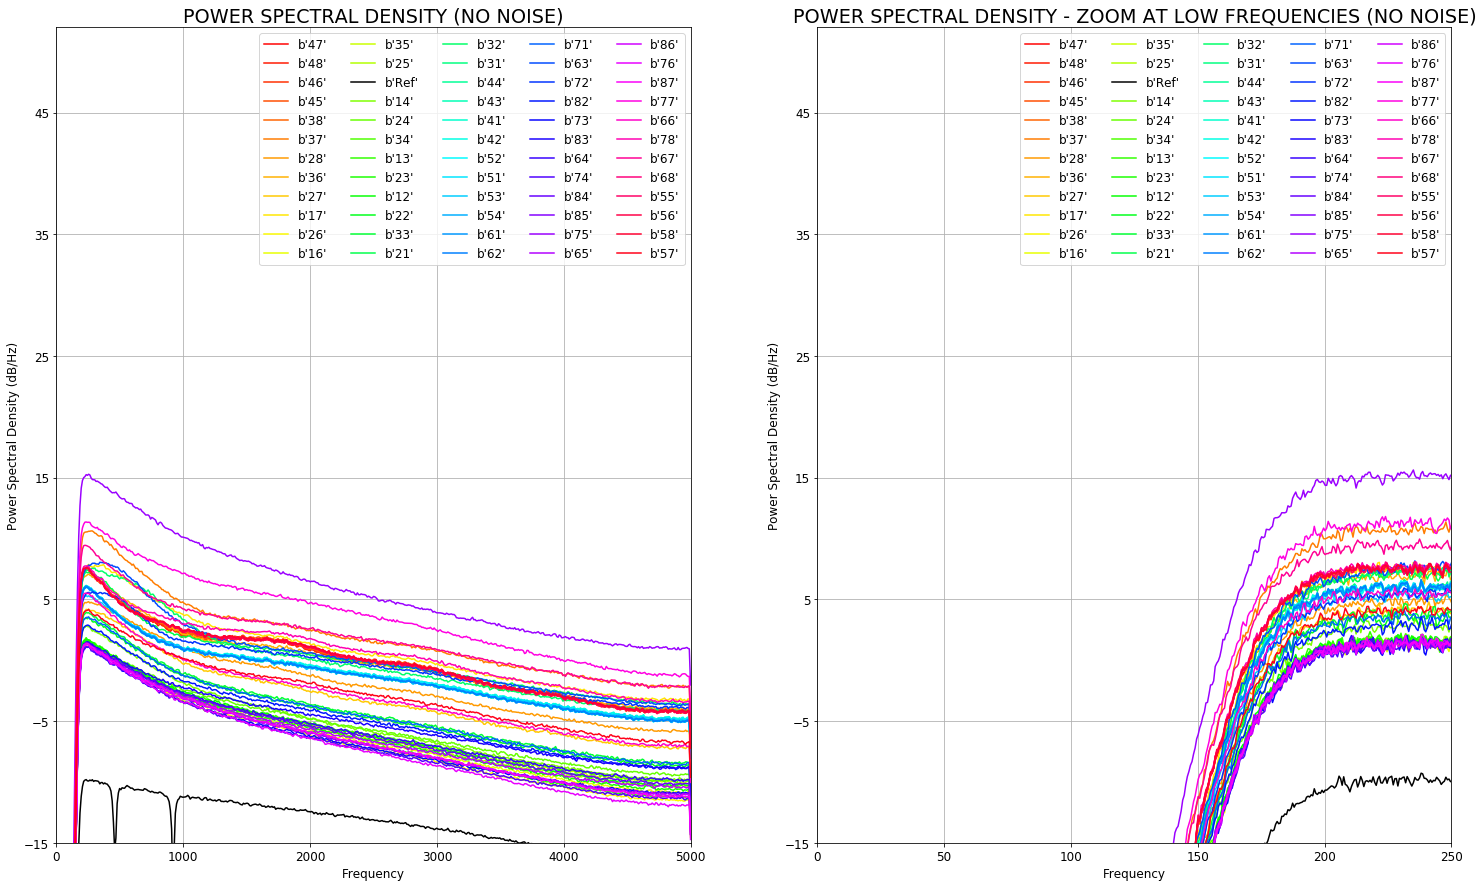

In [113]:
#PREFILTERING
#Low Frequencies
readings_rows = range(readings.shape[0])
reading_columns = range(readings.shape[1])
pre_filtered_readings = pd.DataFrame(data = 0, columns=readings.columns, index=readings_rows, dtype = "float32")

b, a = scipy.signal.butter(N = 8, Wn=175, btype='highpass', analog=False, output='ba', fs=fs)
for x in tqdm(range(readings.shape[1])):
    pre_filtered_readings.values[:,x] = scipy.signal.filtfilt(b, a, readings.values[:,x])
    
# Find noisy peaks on Ref channel
from scipy import signal
freqs,spectrogram = signal.welch(pre_filtered_readings[b'Ref'].values,fs=10000,nfft=1024)
noise_freq = freqs[spectrogram.argmax()]
print(noise_freq)
Q = 30
b, a = scipy.signal.iirnotch(noise_freq, Q, fs)
Q = 60
b_2, a_2 = scipy.signal.iirnotch(2*noise_freq, Q, fs)

channel = pre_filtered_readings[b'Ref'].values
pre_filtered_ref = scipy.signal.filtfilt(b, a, channel)
pre_filtered_ref = scipy.signal.filtfilt(b_2, a_2, pre_filtered_ref) 
pre_filtered_readings[b'Ref'] = pre_filtered_ref

#Prefiltered plot
colormap = cm.get_cmap('hsv')
plt.figure(figsize=(25,15))
plt.subplot(1, 2, 1)
plt.rcParams.update({'font.size': 16})
plt.title('POWER SPECTRAL DENSITY (NO NOISE)')
column = 0
for electrode in tqdm(readings.columns):
    if electrode == b'Ref':
        plt.psd(pre_filtered_readings[electrode],1024 ,Fs=fs,window=np.hamming(1024),noverlap=50, label=electrode, color = "#000000")
    else:
        plt.psd(pre_filtered_readings[electrode],1024 ,Fs=fs,window=np.hamming(1024),noverlap=50, label=electrode, color = colormap(np.linspace(0, 1, 60))[column])
    plt.axis([0,5000,-15,52])
    column +=1
plt.rcParams.update({'font.size': 12})
plt.legend(loc='upper right', ncol=5)


plt.subplot(1, 2, 2)
plt.rcParams.update({'font.size': 16})
plt.title('POWER SPECTRAL DENSITY - ZOOM AT LOW FREQUENCIES (NO NOISE)')
column = 0
for electrode in tqdm(readings.columns):
    if electrode == b'Ref':
        plt.psd(pre_filtered_readings[electrode],1024*16 ,Fs=fs,window=np.hamming(1024*16),noverlap=50, label=electrode, color = "#000000")
    else:
        plt.psd(pre_filtered_readings[electrode],1024*16 ,Fs=fs,window=np.hamming(1024*16),noverlap=50, label=electrode, color = colormap(np.linspace(0, 1, 60))[column])
    plt.axis([0,250,-15,52])
    column +=1
plt.rcParams.update({'font.size': 12})
plt.legend(loc='upper right', ncol=5)


plt.show()

### SEARCHING FOR THE FREQUENCIES OF SPIKES
In this section we searched for the frequencies which are typical of spikes doing a STFT (Short Time Fourier Transform).
<br>
We found the typical frequencies of 300Hz 3000Hz cited in various papers well fit our data. 
<br>
- Low frequencies are important for spike amplitude (especially for the slowest ones)
- High frequencies are important for the morphology of the spikes

"#Short Time Fourier Transform\nplt.figure(figsize=(26,18))\nplt.subplot(2, 1, 2)\nf, t, Sxx = scipy.signal.stft(x = pre_filtered_readings[electrode_example].values[t_initial:t_initial+lenght], fs=fs, window='boxcar', nperseg=2**6, noverlap=None, nfft=2**9)\nplt.pcolormesh(t*fs+t_initial, f, np.abs(Sxx))\nplt.colorbar()\nplt.ylabel('Frequency [Hz]')\nplt.xlabel('Samples')\nplt.axis\nplt.ylim([0,5000])\n\nplt.show()"

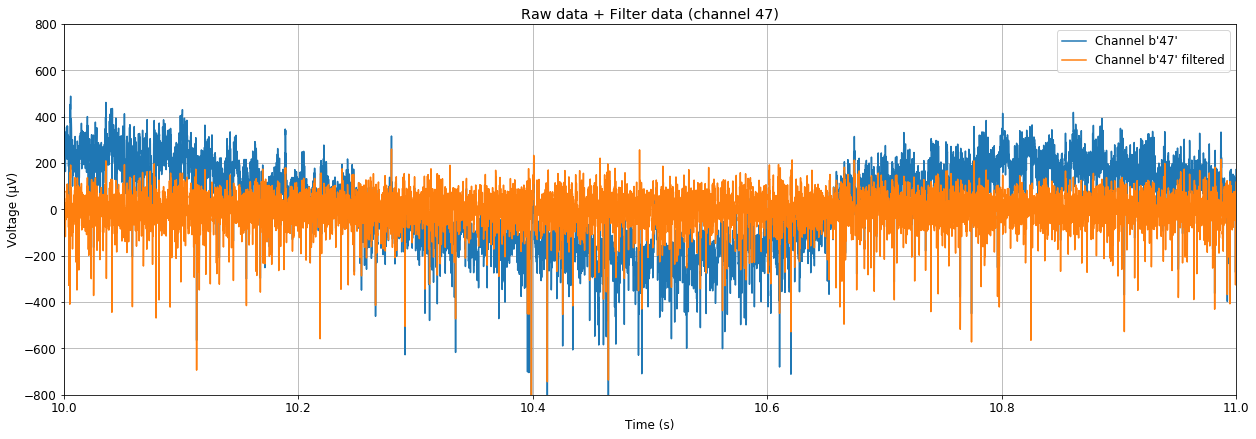

In [114]:
electrode_example = b'47' #Change the name here to change the electrode

t_initial = 10 #Change the number here to select a different initial position
lenght = 1 #Change the number here to enlarge or reduce the x axis (time)

#Time domain signal
plt.figure(figsize=(21,15))
plt.subplot(2, 1, 1)
label = "Channel " + str(electrode_example)
plt.plot([x/10000 for x in range (0,readings.shape[0])],readings[electrode_example].values, label=label)
plt.plot([x/10000 for x in range (0,readings.shape[0])],pre_filtered_readings[electrode_example].values, label=label+' filtered')

plt.axis([t_initial,t_initial+lenght, -800, 800])
plt.title('Raw data + Filter data (channel 47)')
plt.ylabel ('Voltage (\u03BCV)')
plt.xlabel('Time (s)')
plt.grid()
plt.legend(loc="upper right")

'''#Short Time Fourier Transform
plt.figure(figsize=(26,18))
plt.subplot(2, 1, 2)
f, t, Sxx = scipy.signal.stft(x = pre_filtered_readings[electrode_example].values[t_initial:t_initial+lenght], fs=fs, window='boxcar', nperseg=2**6, noverlap=None, nfft=2**9)
plt.pcolormesh(t*fs+t_initial, f, np.abs(Sxx))
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Samples')
plt.axis
plt.ylim([0,5000])

plt.show()'''

### FILTERING
We tried the following filters:
1. FIR (Hamming window)
2. FIR (Blackman-Nuttall window)
3. IIR (Butterworth)

We found the filter order was not so relevant and we decided to filter the signal with the Butterworth one (due to maximal flatness) between 300Hz and 3000Hz 

100%|██████████| 60/60 [00:10<00:00,  5.79it/s]


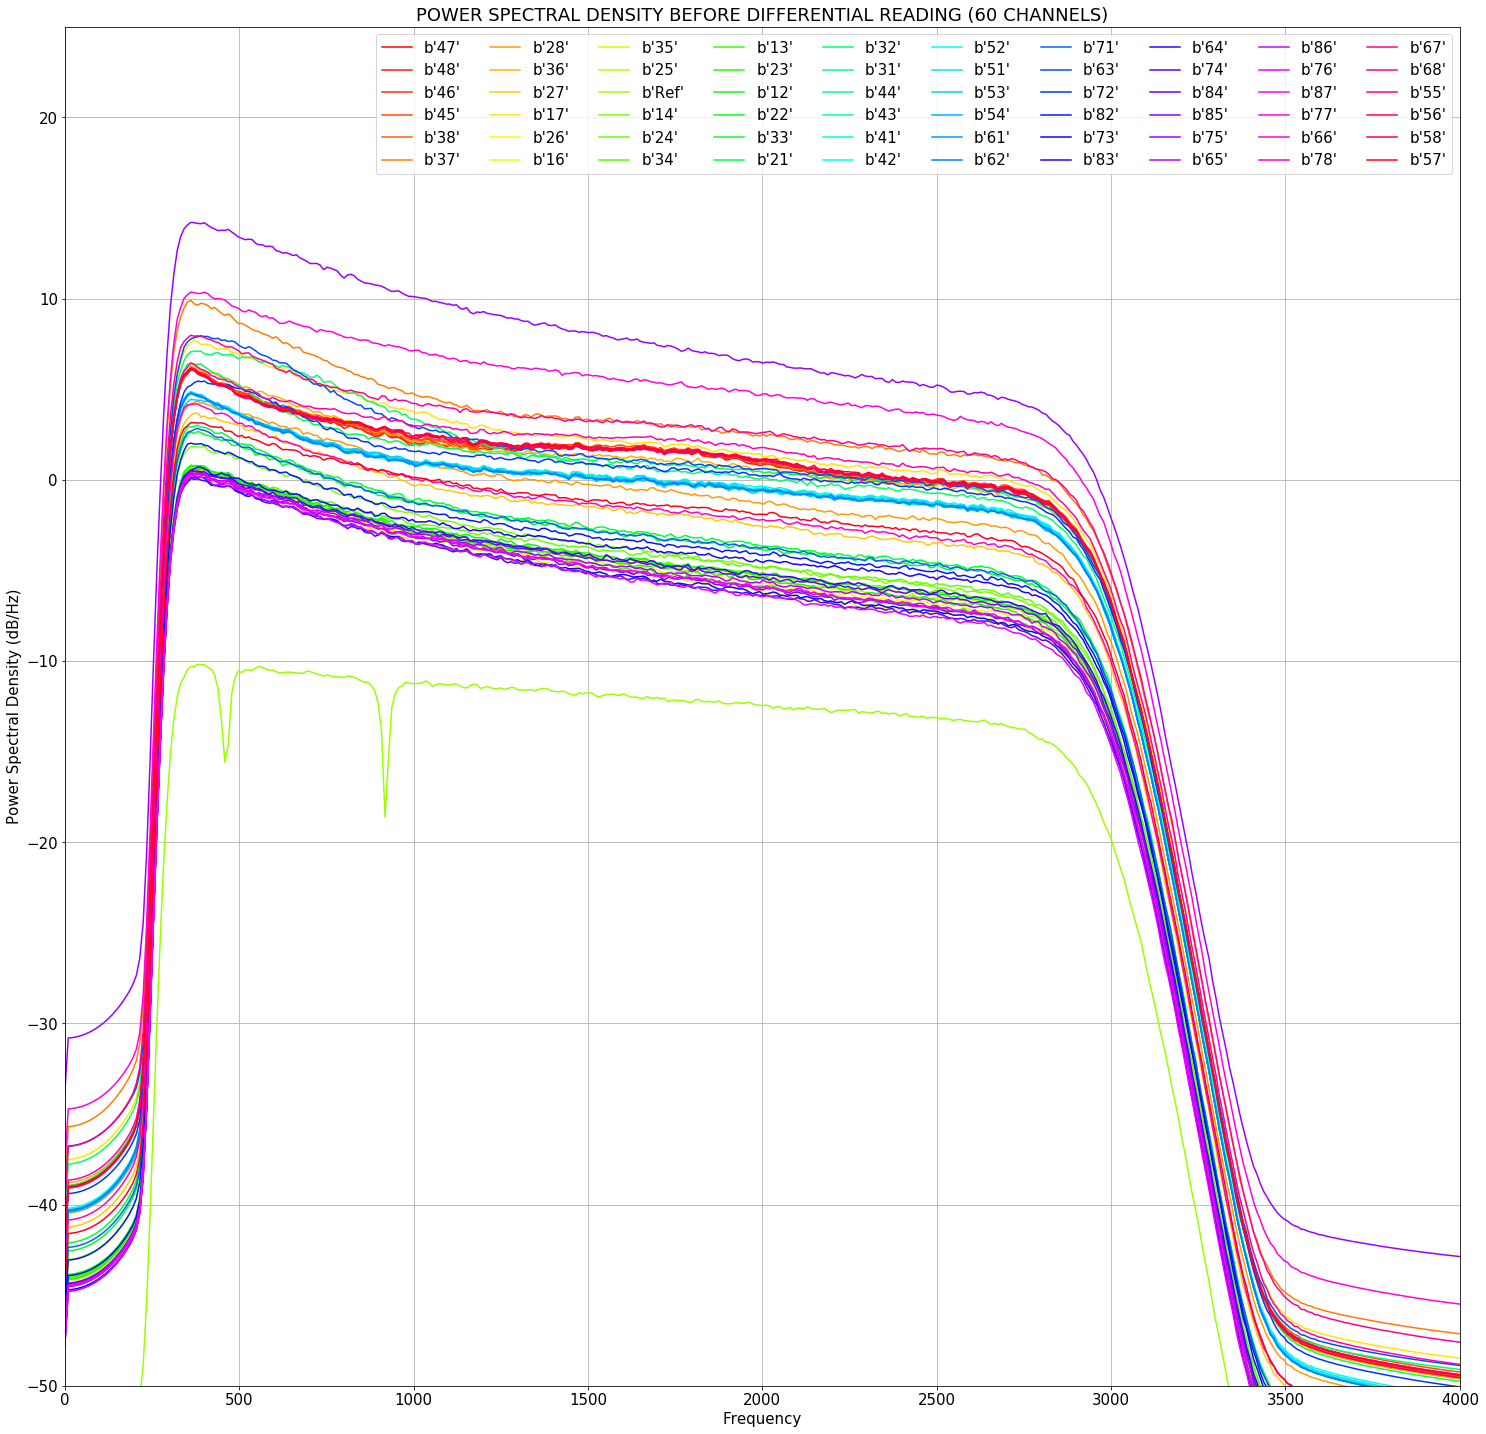

In [115]:
lowcut = 300
highcut = 3000

readings_rows = range(readings.shape[0])
reading_columns = range(readings.shape[1])
filtered_readings = pd.DataFrame(data = 0, columns=pre_filtered_readings.columns, index=readings_rows, dtype = "float32")

elab = pre_filtered_readings.values

order=8
for x in tqdm(range(filtered_readings.shape[1])):
    filtered_readings.values[:,x] = butter_bandpass_filter(elab[:,x], lowcut, highcut, fs, order=order)
    
plt.figure(figsize=(25,25))
plt.rcParams.update({'font.size': 15})
column = 0
colormap = cm.get_cmap('hsv')
for electrode in tqdm(filtered_readings.columns):
    plt.psd(filtered_readings[electrode], 1024, Fs = fs, window=np.hamming(1024), noverlap=50, label=electrode, color = colormap(np.linspace(0, 1, 60))[column])
    plt.axis([0,4000,-50,25])
    plt.title('POWER SPECTRAL DENSITY BEFORE DIFFERENTIAL READING (60 CHANNELS)')
    column +=1
plt.legend(loc='upper right', ncol=10)
plt.show()

del readings
del pre_filtered_readings
del elab

### DIFFERENTIAL READING
We subtracted the reference channel and executed a differential reading

In [116]:
for electrode in filtered_readings.columns:
    filtered_readings[electrode] = filtered_readings[electrode] - filtered_readings[b'Ref']
filtered_readings = filtered_readings.drop([b'Ref'],axis = 1)

### CORRELATION MATRIX AND DELETION OF HIGH CORRELATED CHANNELS

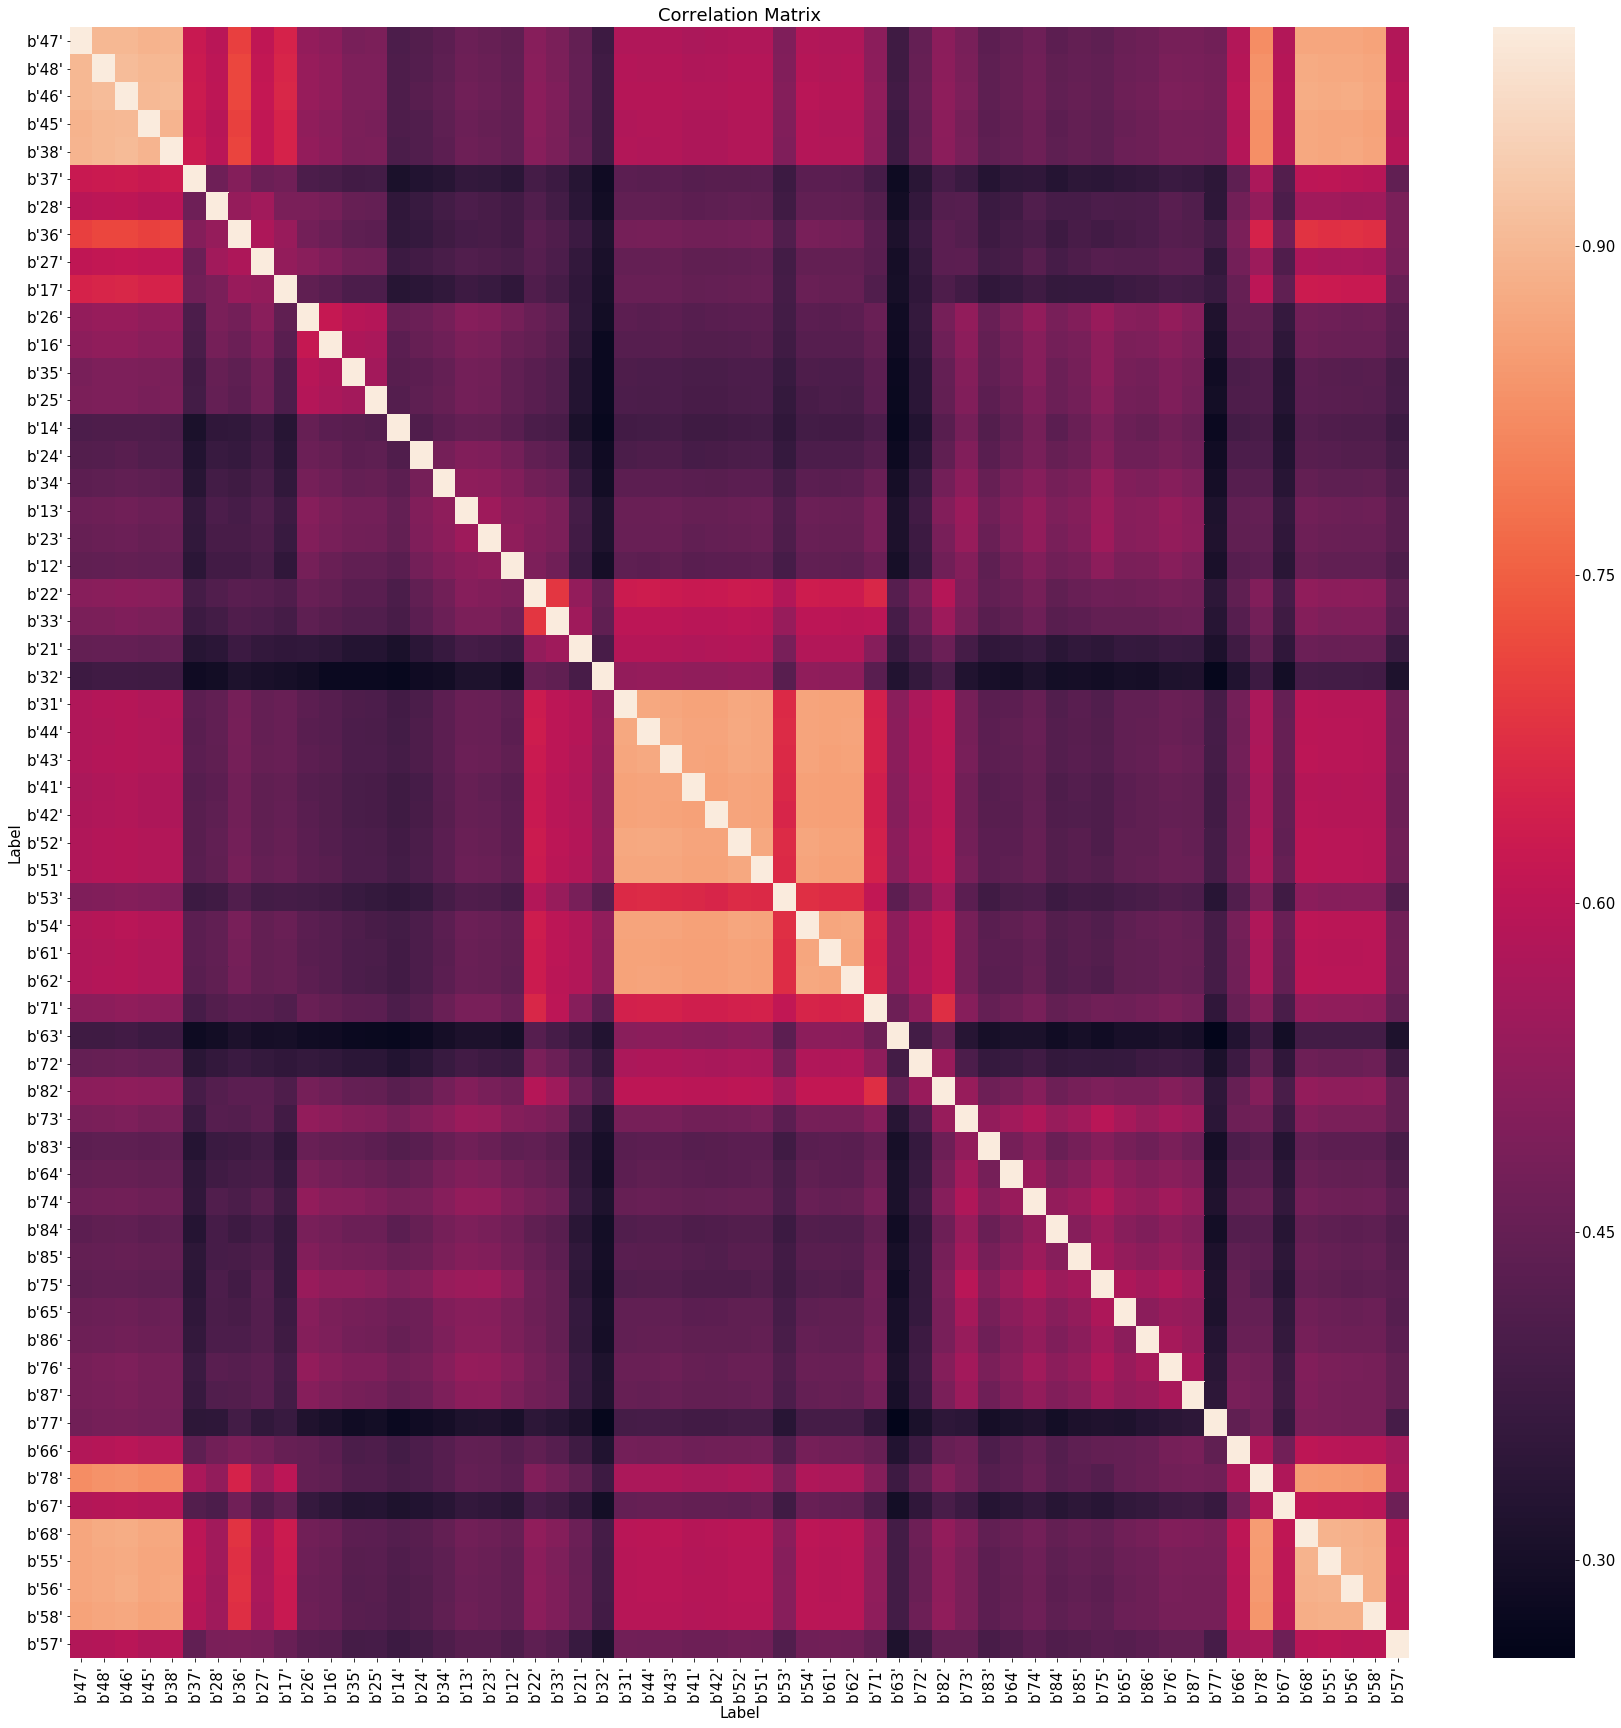

In [117]:
corr_matrix = filtered_readings.iloc[:50000,:].corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr_matrix, annot=False, yticklabels = True)
plt.title('Correlation Matrix')
plt.show()


The following 19 channels are correlated:  {b'55', b'43', b'42', b'61', b'68', b'62', b'56', b'47', b'41', b'31', b'54', b'48', b'38', b'44', b'51', b'46', b'58', b'45', b'52'} 
With a correlation over: 85.0 %



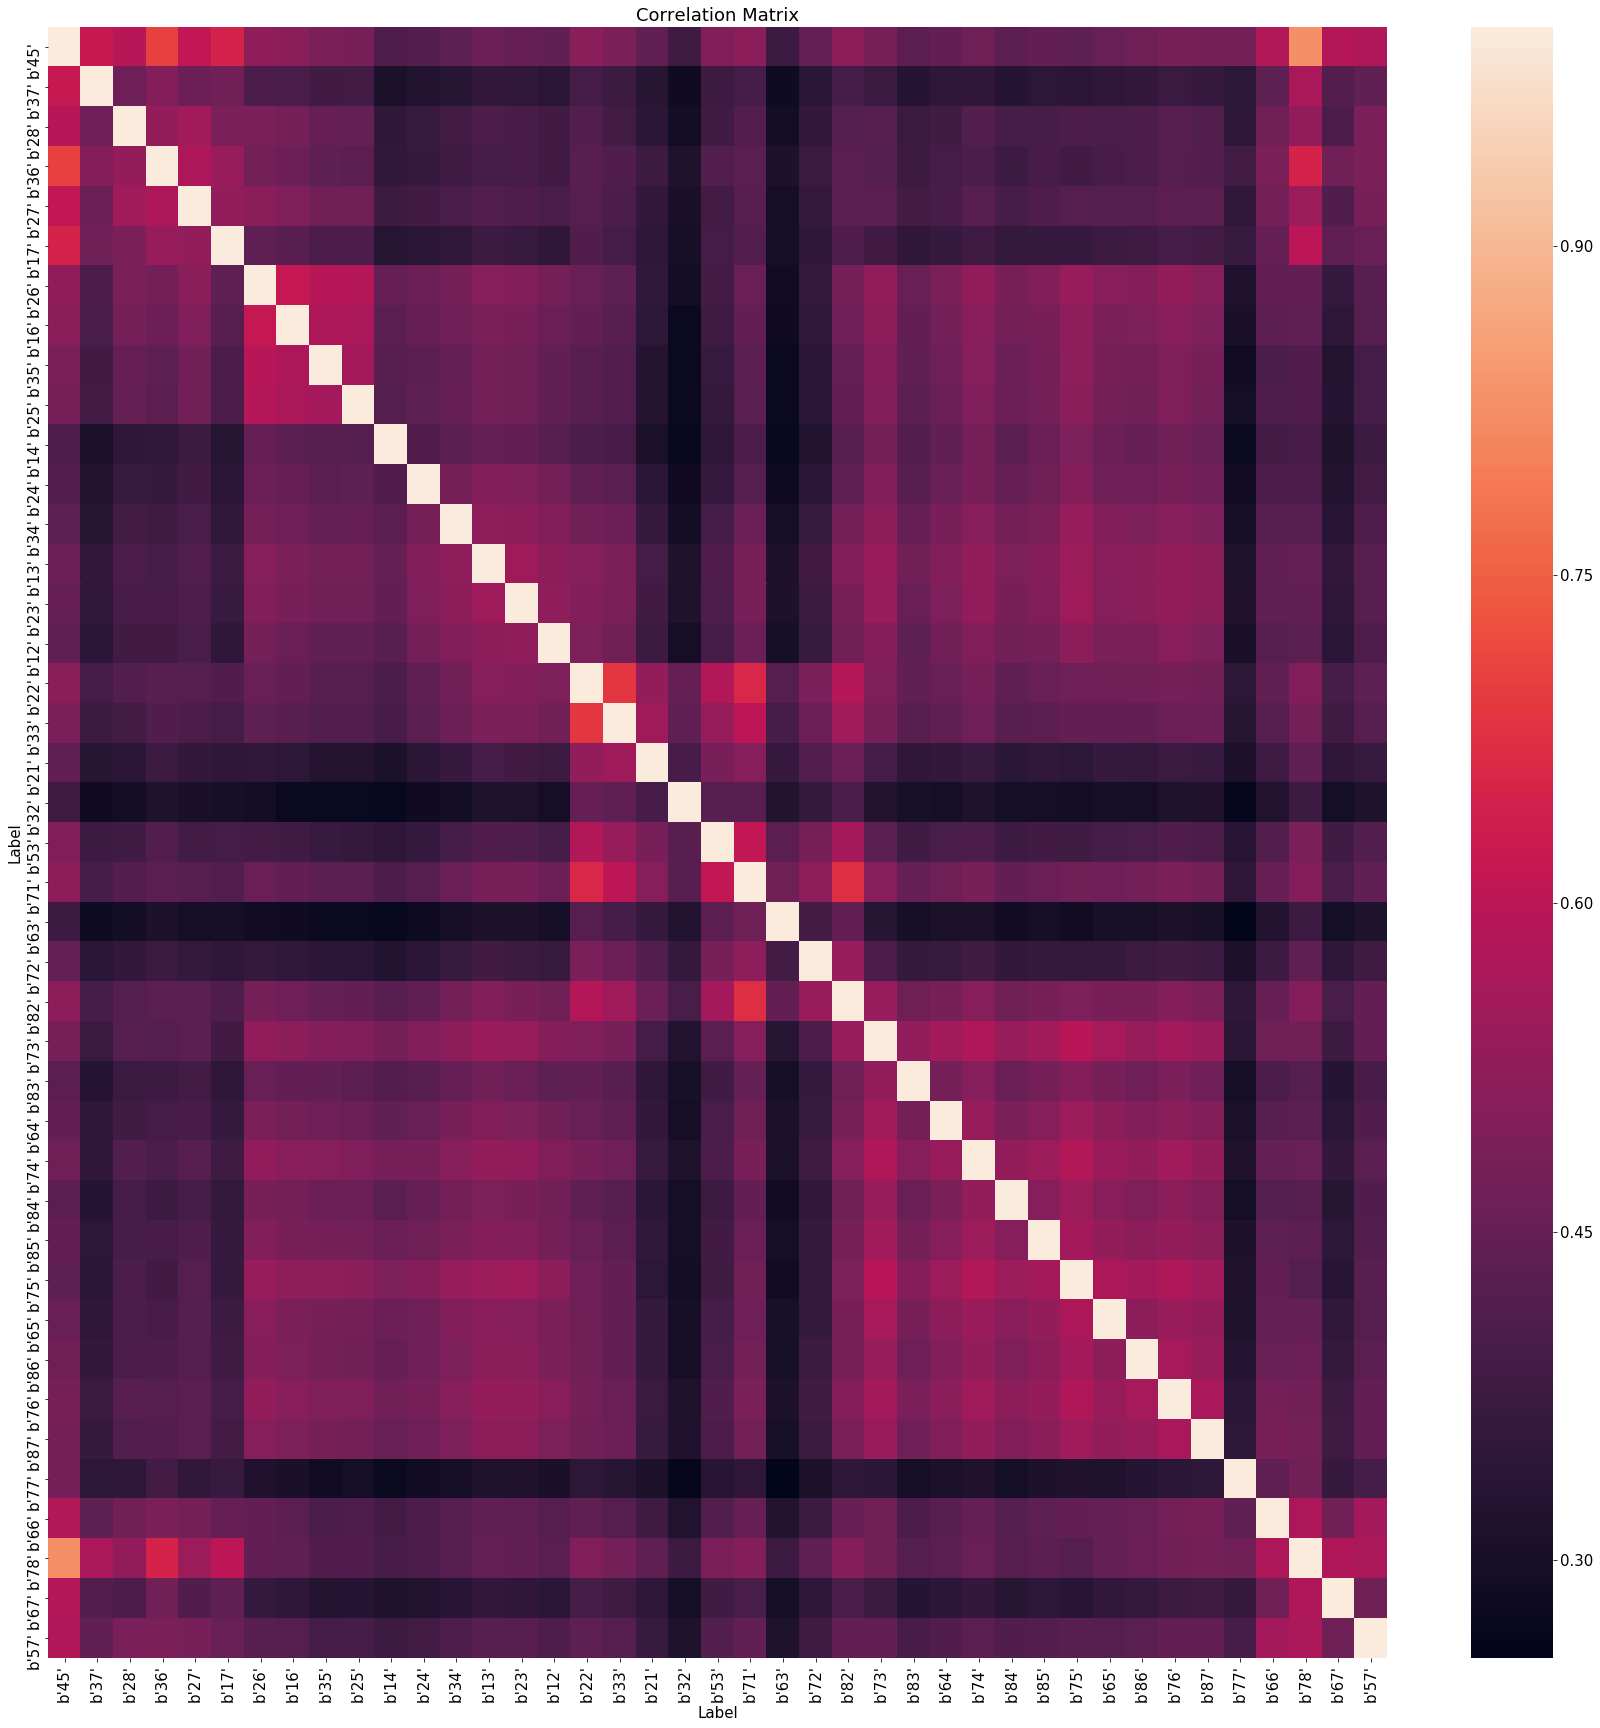

In [118]:
max_corr = 0.85

correlated_channels = set()

for column in corr_matrix.columns:
    for row in corr_matrix.index:
        if row != column and corr_matrix[row][column] > max_corr:
            correlated_channels.add(row)

print("\nThe following", len(correlated_channels),"channels are correlated: ", correlated_channels,"\nWith a correlation over:", max_corr*100, "%\n")

absolute_mean = dict()
for electrode in correlated_channels:
    absolute_mean[electrode] = np.mean(abs(filtered_readings[electrode].values))
    
#Keeping only the channel that has maximum absolute value
maximum_value = float(0)
maximum_name = ""
for electrode in absolute_mean:
    if absolute_mean[electrode] > maximum_value:
        maximum_value = absolute_mean[electrode]
        maximum_name = electrode

correlated_channels.remove(maximum_name)

#Deleting all the other channels from the correlation matrix
corr_matrix = corr_matrix.drop(labels = correlated_channels, axis=0)
corr_matrix = corr_matrix.drop(labels = correlated_channels, axis=1)

#Deleting all the other channels from the filtered readings
filtered_readings = filtered_readings.drop(columns = correlated_channels)

plt.figure(figsize=(30,30))
sns.heatmap(corr_matrix, annot=False, yticklabels = True)
plt.title('Correlation Matrix')
plt.show()

### THRESHOLD
We tried two ways of calculating the threshold:
1. Standard Deviation (SD)
2. Median Absolute Deviation (MAD)

We found that the two values didn't differ very much. Thus we opted for the estimator which better identified the noise variance, which is the MAD.
<br>

In [119]:
#You can choose "MAD" and "STD"
method = "MAD"

#Multiple
n = 4

In [120]:
if method == "MAD":
    deviation_list = pd.DataFrame(data = 0, columns=filtered_readings.columns, index=range(1))
    threshold = pd.DataFrame(data = 0, columns=filtered_readings.columns, index = range(1))
    for electrode in tqdm(filtered_readings.columns):
        deviation_list[electrode] = scipy.stats.median_absolute_deviation(filtered_readings[electrode].values)
        threshold[electrode] = (deviation_list[electrode])*n  
    
elif method == "STD":
    deviation_list = pd.DataFrame(data = 0, columns=filtered_readings.columns, index=range(1))
    threshold = pd.DataFrame(data = 0, columns=filtered_readings.columns, index = range(1))
    for electrode in tqdm(filtered_readings.columns):
        deviation_list[electrode] = np.std(filtered_readings[electrode].values)
        threshold[electrode] = (np.std(filtered_readings[electrode].values))*n

100%|██████████| 41/41 [00:11<00:00,  3.46it/s]


In [121]:
np.full(filtered_readings.shape[0],128)

array([128, 128, 128, ..., 128, 128, 128])

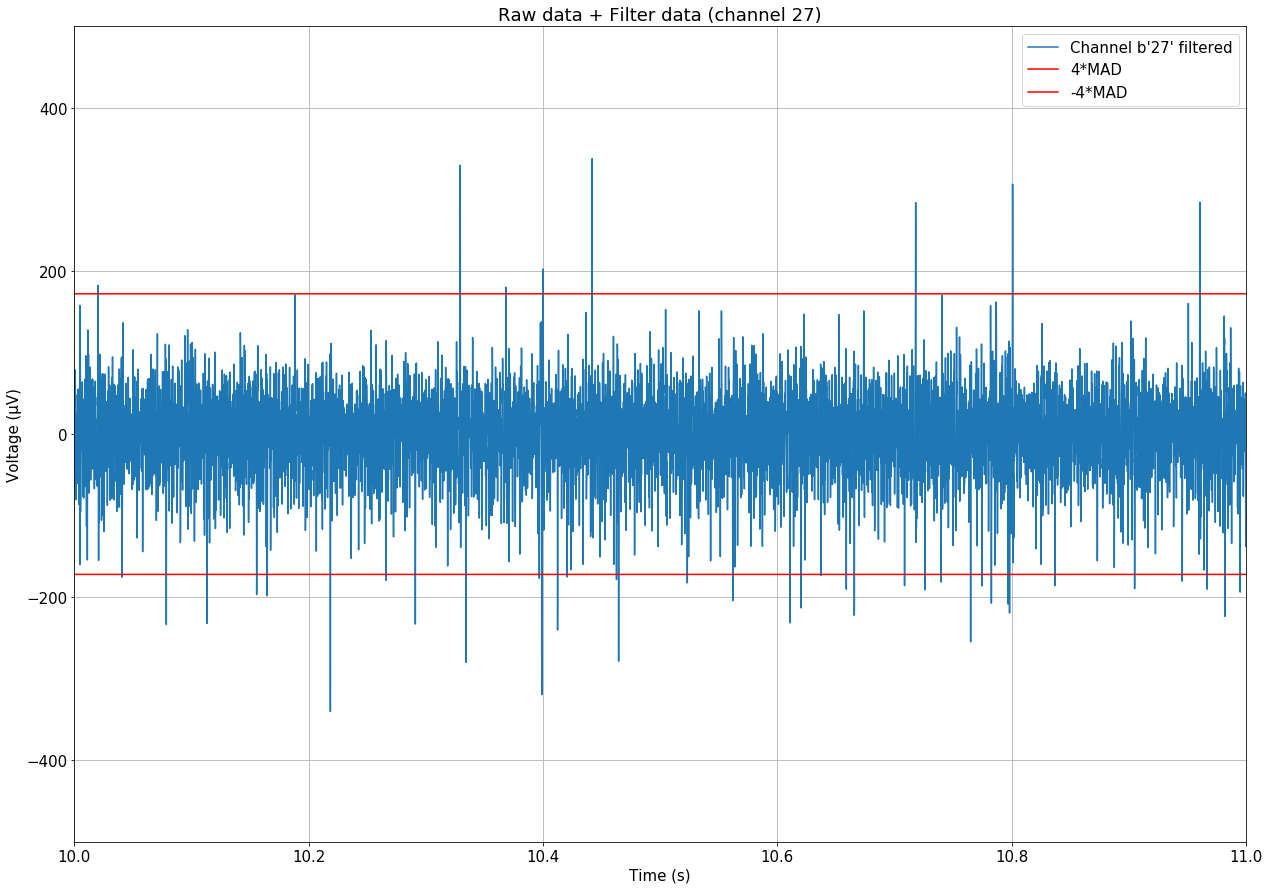

In [122]:
electrode_example = b'27' #Change the name here to change the electrode

t_initial = 10 #Change the number here to select a different initial position
lenght = 1 #Change the number here to enlarge or reduce the x axis (time)

#Time domain signal
plt.figure(figsize=(21,15))
label = "Channel " + str(electrode_example)
plt.plot([x/10000 for x in range (0,filtered_readings.shape[0])],filtered_readings[electrode_example].values, label=label+' filtered')
plt.plot([x/10000 for x in range (0,filtered_readings.shape[0])],np.full(filtered_readings.shape[0],threshold[electrode_example]),'r',label='4*MAD')
plt.plot([x/10000 for x in range (0,filtered_readings.shape[0])],np.full(filtered_readings.shape[0],-threshold[electrode_example]),'r',label = '-4*MAD')


plt.axis([t_initial,t_initial+lenght, -500, 500])
plt.title('Raw data + Filter data (channel 27)')
plt.ylabel ('Voltage (\u03BCV)')
plt.xlabel('Time (s)')
plt.grid()
plt.legend(loc="upper right")

### EXTRACT WAVEFORM
We then extracted the signal which exceeded the threshold. This signal is presumably the spikes

In [123]:
legend = pd.DataFrame(data = 0, columns=filtered_readings.columns, index=["corresponding number"])
indexes = []
aligned_indexes = []
extracted = []

i = 0
for electrode in tqdm(filtered_readings.columns):
    legend[electrode] = i
    sgn = filtered_readings[electrode].values
    thr = float(threshold[electrode].values[0])
    indexes.append(DetectSpike(segnale = sgn, soglia = thr, fs = fs))
    aligned_indexes.append(AlignSpike(segnale = sgn, indici = indexes[i], soglia = thr, fs = fs))
    extracted.append(ExtractSpike(segnale = sgn, indici = aligned_indexes[i], fs = fs))
    i+=1
    
del indexes

100%|██████████| 41/41 [06:22<00:00,  9.33s/it]


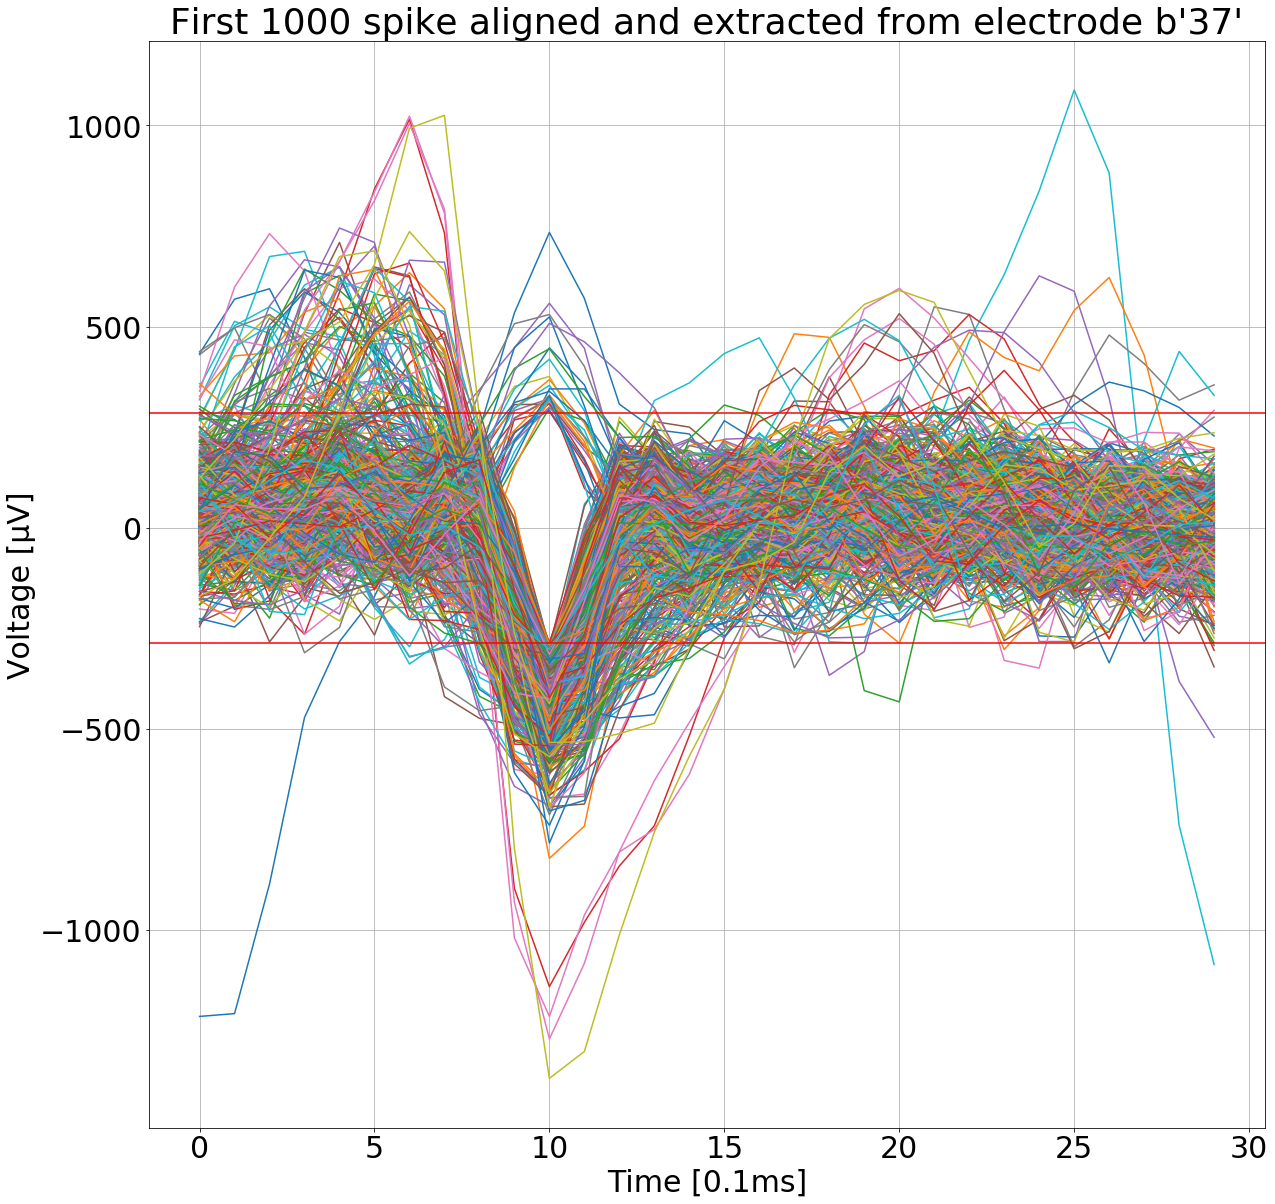

In [124]:
electrode_example = b'37' #Change the name here to change electrode

spike_count = 1000  #Change the number here to increase or decrase the spikes to draw. 
                    #To see all spikes use: len(extracted[legend[electrode_example]])

#Plot
plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 30})
plt.xlabel('Time [0.1ms]')
plt.ylabel('Voltage [\u03BCV]')
i=0
while (i<spike_count):
    plt.plot(extracted[legend[electrode_example].values[0]][i])
    i += 1
plt.axhline(threshold[electrode_example].values, 0,1, color="#FF0000")
plt.axhline(-threshold[electrode_example].values, 0,1, color="#FF0000")
title = str("First ") + str(i) + str(" spike aligned and extracted from electrode ") + str(electrode_example)
plt.title(title)
plt.grid()
plt.show()

### EXTRACT SPIKE CHARACTERISTICS
We used 3 components principal analysis to extract and plot the characteristics of the spikes detected
<br>
30 dimensions (there were 30 sample points per spike) --> 3 Dimensions

In [125]:
principal_components = []
for electrode in filtered_readings.columns:
    print("\n\nELECTRODE: ", electrode)
    principal_components.append(EseguiPCA(dati=extracted[legend[electrode].values[0]], n=3, show=False))



ELECTRODE:  b'45'

Signal standardized
Mean:  -5.181781036017781e-18 
Variance:  1.0000000000000004 



ELECTRODE:  b'37'

Signal standardized
Mean:  -1.7049615735095386e-18 
Variance:  0.9999999999999984 



ELECTRODE:  b'28'

Signal standardized
Mean:  3.9789871368187015e-18 
Variance:  1.0000000000000004 



ELECTRODE:  b'36'

Signal standardized
Mean:  1.5928900401347323e-18 
Variance:  1.0000000000000027 



ELECTRODE:  b'27'

Signal standardized
Mean:  -1.180513653431603e-18 
Variance:  1.0000000000000004 



ELECTRODE:  b'17'

Signal standardized
Mean:  4.7581609696043785e-18 
Variance:  1.0000000000000022 



ELECTRODE:  b'26'

Signal standardized
Mean:  4.6890344315575015e-18 
Variance:  0.999999999999994 



ELECTRODE:  b'16'

Signal standardized
Mean:  -2.2128277334307687e-17 
Variance:  1.0000000000000022 



ELECTRODE:  b'35'

Signal standardized
Mean:  1.5649171859106388e-17 
Variance:  0.9999999999999996 



ELECTRODE:  b'25'

Signal standardized
Mean:  1.2600798632541

### CLUSTERING
We tried 3 different ways of clustering the PCA results:
1. DBSCAN
2. K-Means
3. Hierarchical

In [126]:
plt.rcParams.update({'font.size': 20})

  0%|          | 0/41 [00:00<?, ?it/s]



ELECTRODE:  b'45'
Total spikes 27996

Spike detected as noise 1170

Only one cluster detected

Blue spikes: 26826


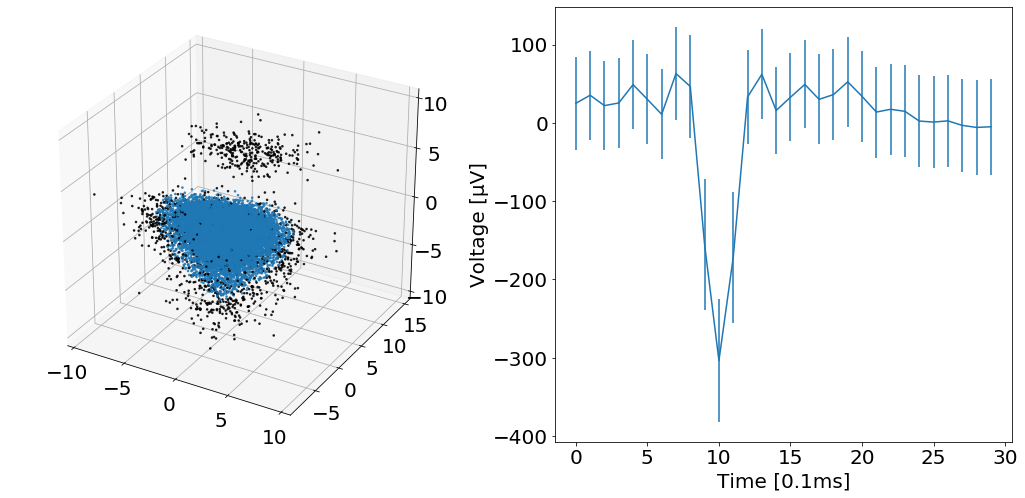

  2%|▏         | 1/41 [00:02<01:46,  2.66s/it]



ELECTRODE:  b'37'
Total spikes 16670

Spike detected as noise 2111

Number of clusters:  2 
The silhouette score is: 0.4343157946503095

Blue spikes: 13965

Orange spikes: 594


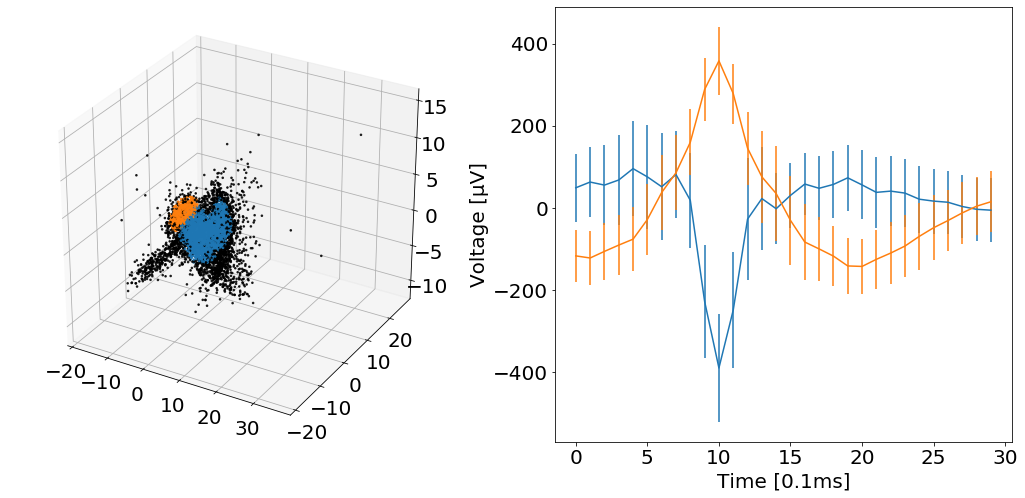

  5%|▍         | 2/41 [00:09<02:27,  3.79s/it]



ELECTRODE:  b'28'
Total spikes 14524

Spike detected as noise 1668

Number of clusters:  2 
The silhouette score is: 0.4610446369783656

Blue spikes: 12675

Orange spikes: 181


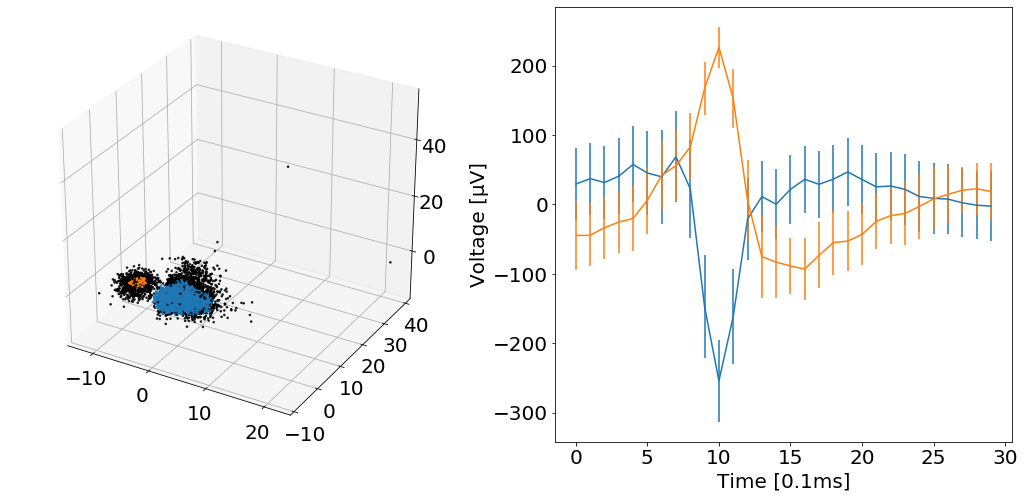

  7%|▋         | 3/41 [00:13<02:25,  3.84s/it]



ELECTRODE:  b'36'
Total spikes 18735

Spike detected as noise 2283

Only one cluster detected

Blue spikes: 16452


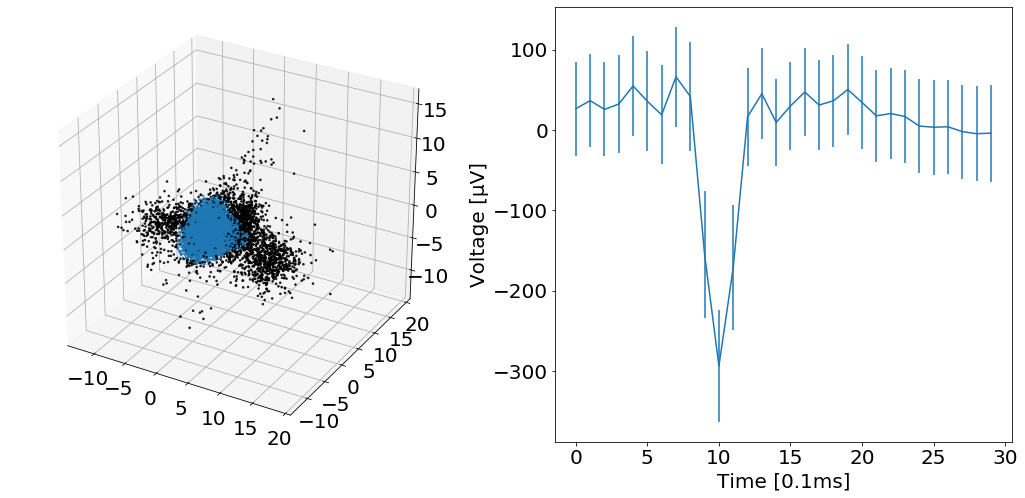

 10%|▉         | 4/41 [00:14<01:57,  3.17s/it]



ELECTRODE:  b'27'
Total spikes 16853

Spike detected as noise 1336

Number of clusters:  2 
The silhouette score is: 0.49576993147322884

Blue spikes: 13386

Orange spikes: 2131


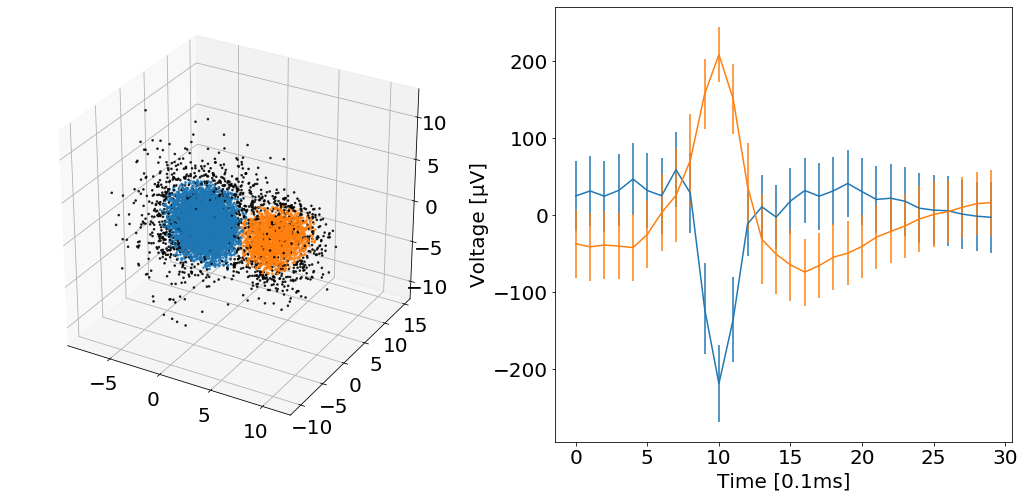

 12%|█▏        | 5/41 [00:19<02:11,  3.65s/it]



ELECTRODE:  b'17'
Total spikes 16974

Spike detected as noise 2116

Number of clusters:  4 
The silhouette score is: 0.43865672944338135

Blue spikes: 13859

Orange spikes: 737

Green spikes: 197

Red spikes: 65


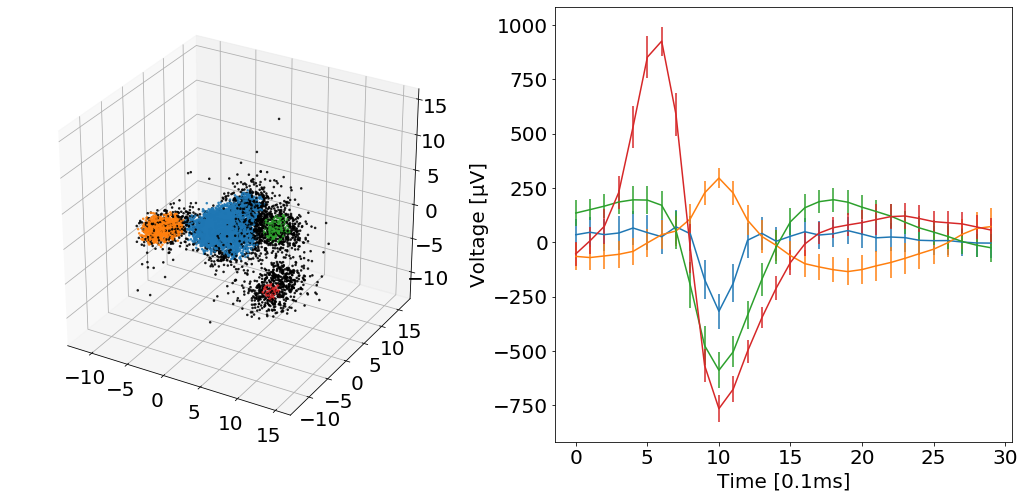

 15%|█▍        | 6/41 [00:24<02:24,  4.12s/it]



ELECTRODE:  b'26'
Total spikes 13840

Spike detected as noise 971

Only one cluster detected

Blue spikes: 12869


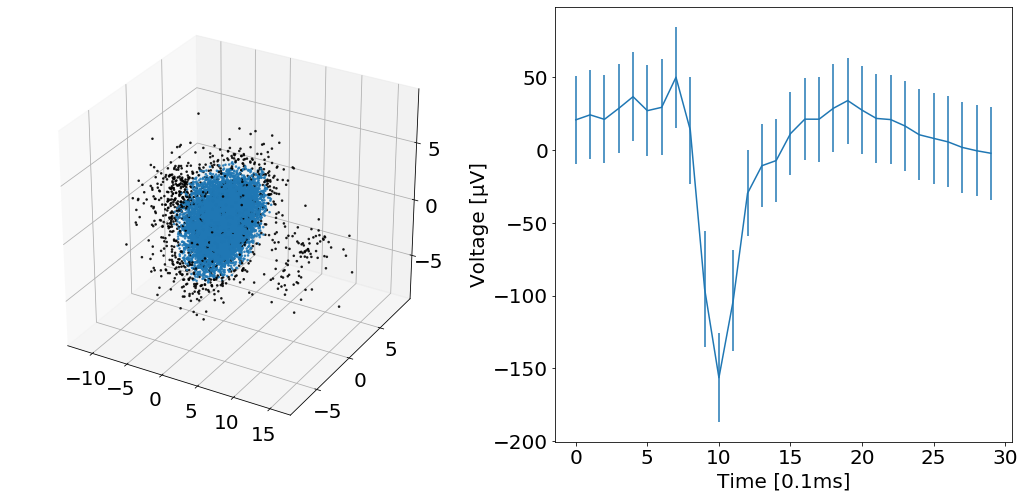

 17%|█▋        | 7/41 [00:25<01:49,  3.22s/it]



ELECTRODE:  b'16'
Total spikes 12630

Spike detected as noise 909

Only one cluster detected

Blue spikes: 11721


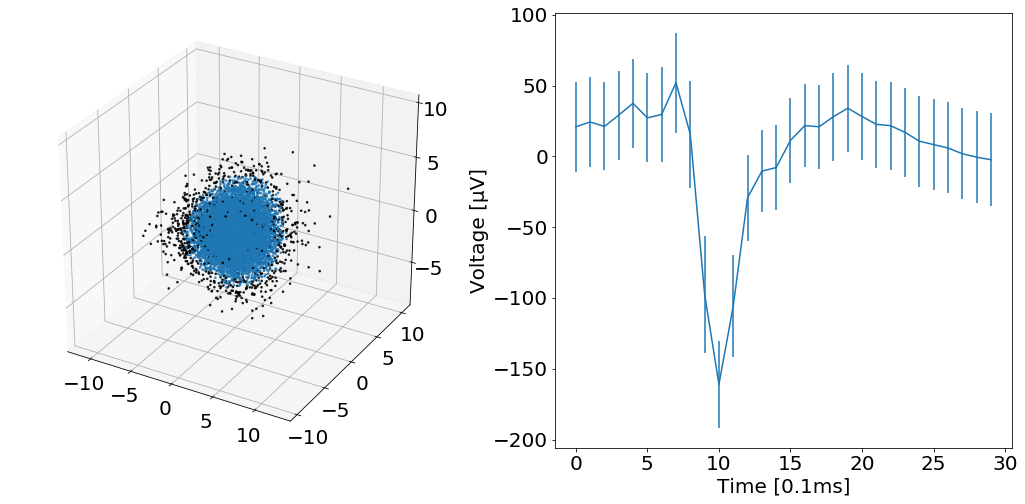

 20%|█▉        | 8/41 [00:26<01:24,  2.56s/it]



ELECTRODE:  b'35'
Total spikes 10776

Spike detected as noise 836

Only one cluster detected

Blue spikes: 9940


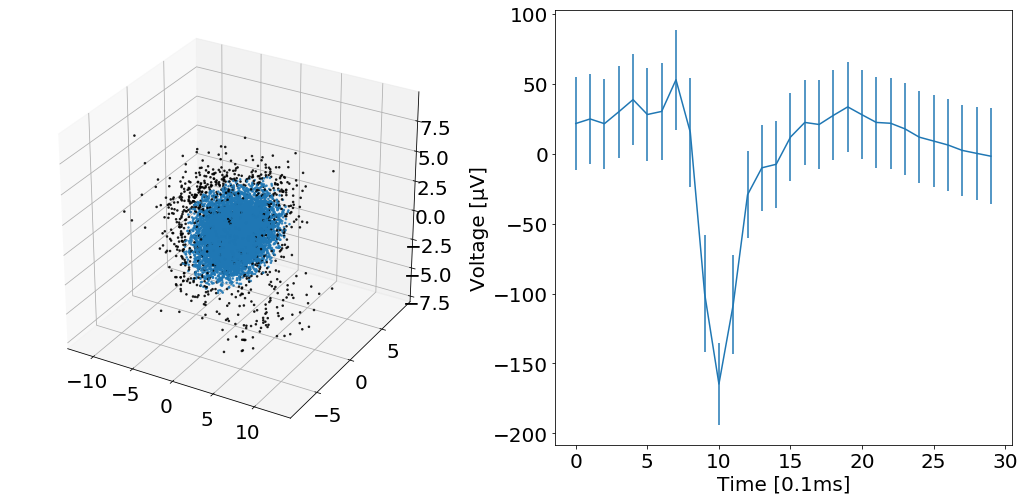

 22%|██▏       | 9/41 [00:27<01:05,  2.05s/it]



ELECTRODE:  b'25'
Total spikes 10735

Spike detected as noise 815

Only one cluster detected

Blue spikes: 9920


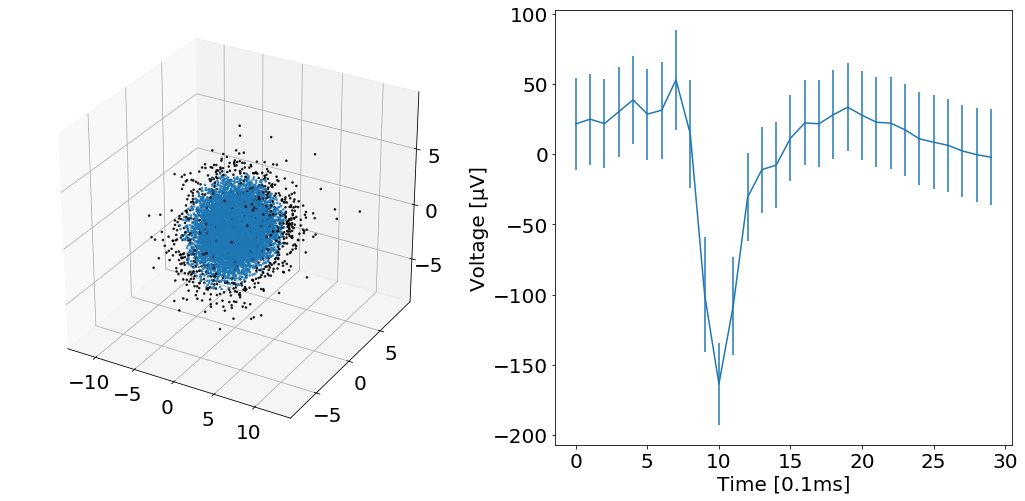

 24%|██▍       | 10/41 [00:28<00:52,  1.70s/it]



ELECTRODE:  b'14'
Total spikes 9136

Spike detected as noise 878

Only one cluster detected

Blue spikes: 8258


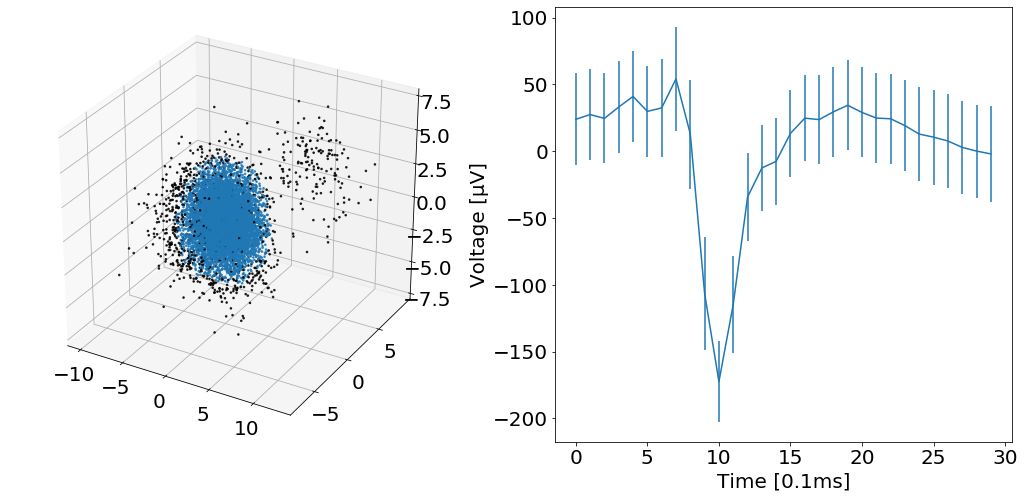

 27%|██▋       | 11/41 [00:29<00:42,  1.42s/it]



ELECTRODE:  b'24'
Total spikes 11045

Spike detected as noise 812

Only one cluster detected

Blue spikes: 10233


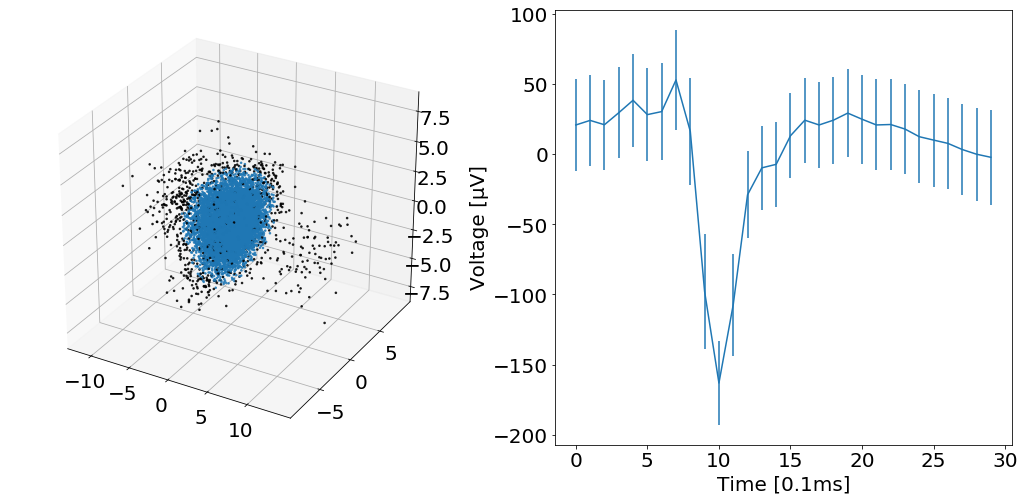

 29%|██▉       | 12/41 [00:30<00:36,  1.26s/it]



ELECTRODE:  b'34'
Total spikes 12555

Spike detected as noise 866

Only one cluster detected

Blue spikes: 11689


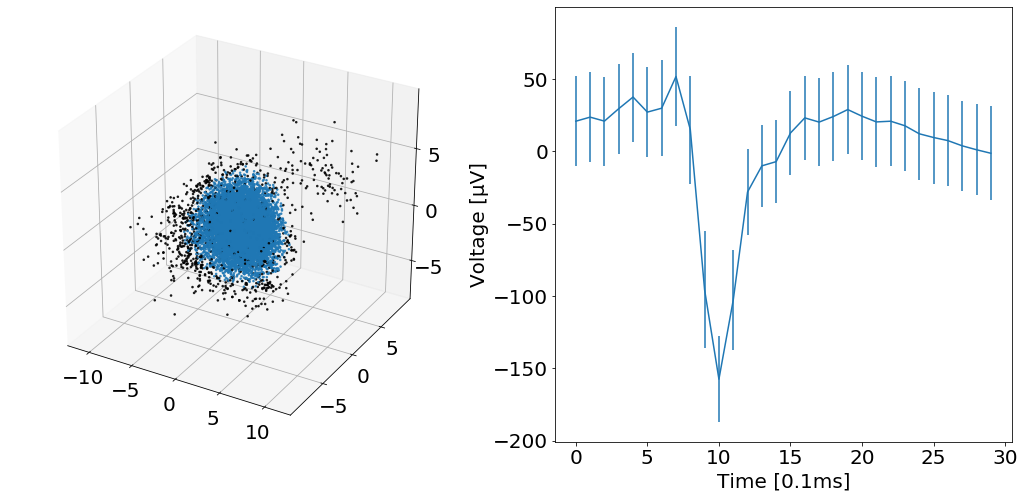

 32%|███▏      | 13/41 [00:31<00:33,  1.20s/it]



ELECTRODE:  b'13'
Total spikes 15104

Spike detected as noise 1023

Only one cluster detected

Blue spikes: 14081


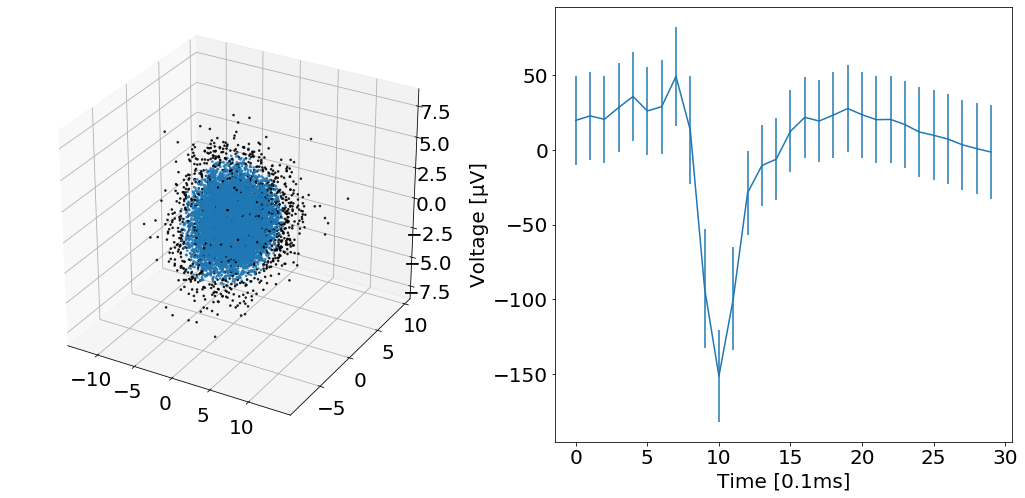

 34%|███▍      | 14/41 [00:32<00:32,  1.19s/it]



ELECTRODE:  b'23'
Total spikes 14546

Spike detected as noise 978

Only one cluster detected

Blue spikes: 13568


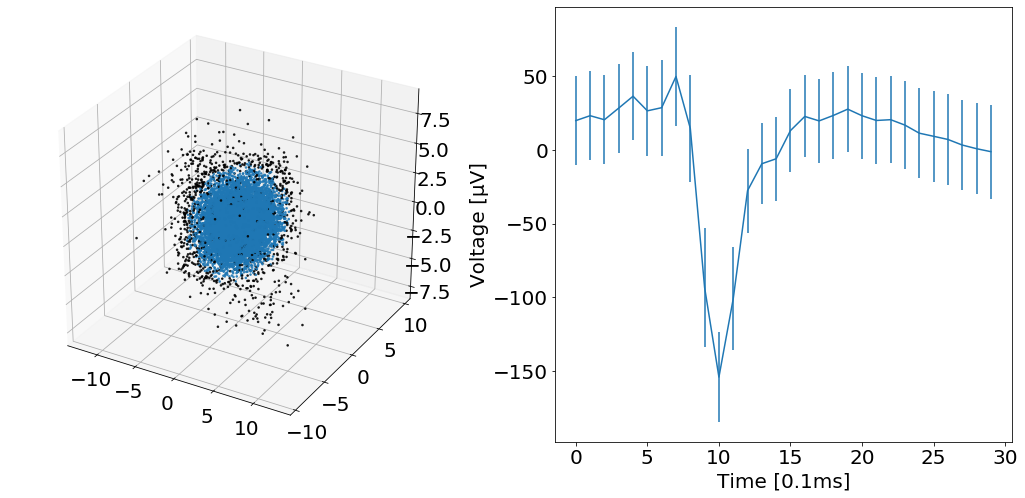

 37%|███▋      | 15/41 [00:33<00:30,  1.18s/it]



ELECTRODE:  b'12'
Total spikes 12988

Spike detected as noise 951

Only one cluster detected

Blue spikes: 12037


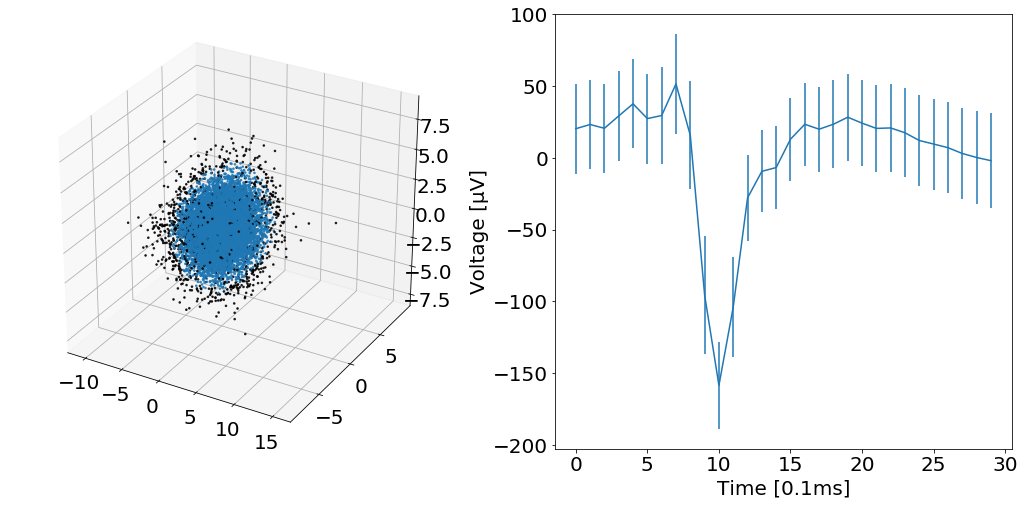

 39%|███▉      | 16/41 [00:34<00:28,  1.12s/it]



ELECTRODE:  b'22'
Total spikes 18712

Spike detected as noise 1243

Number of clusters:  2 
The silhouette score is: 0.4965641852984926

Blue spikes: 16775

Orange spikes: 694


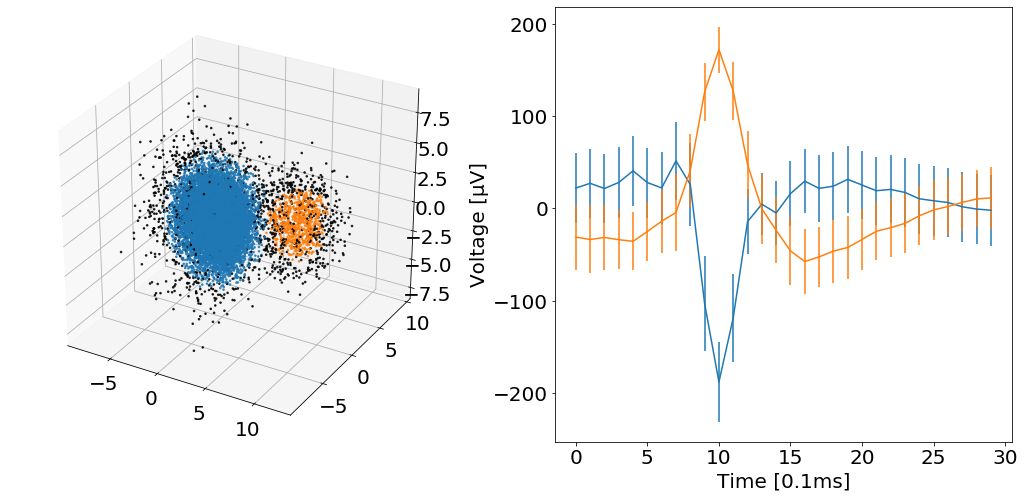

 41%|████▏     | 17/41 [00:40<01:02,  2.58s/it]



ELECTRODE:  b'33'
Total spikes 17281

Spike detected as noise 1342

Number of clusters:  2 
The silhouette score is: 0.4798456701973529

Blue spikes: 15373

Orange spikes: 566


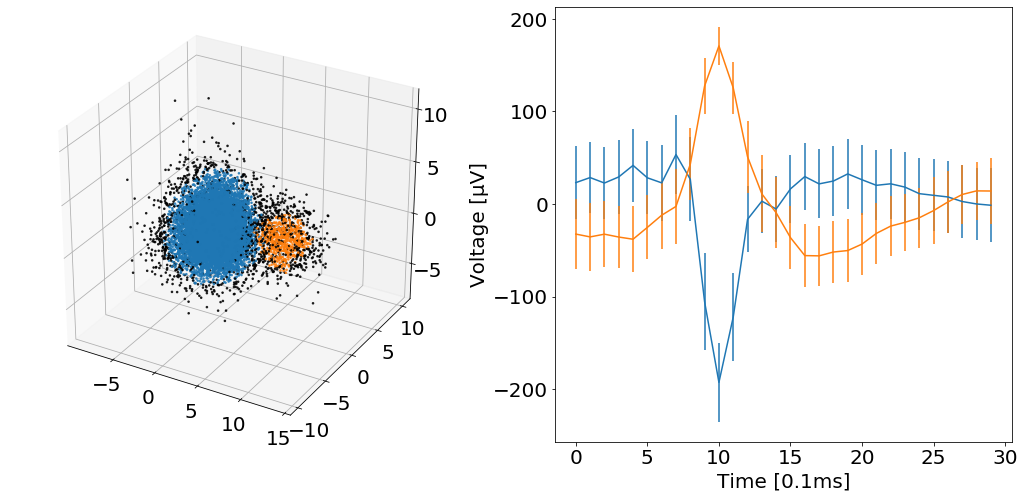

 44%|████▍     | 18/41 [00:45<01:16,  3.31s/it]



ELECTRODE:  b'21'
Total spikes 14238

Spike detected as noise 1922

Only one cluster detected

Blue spikes: 12316


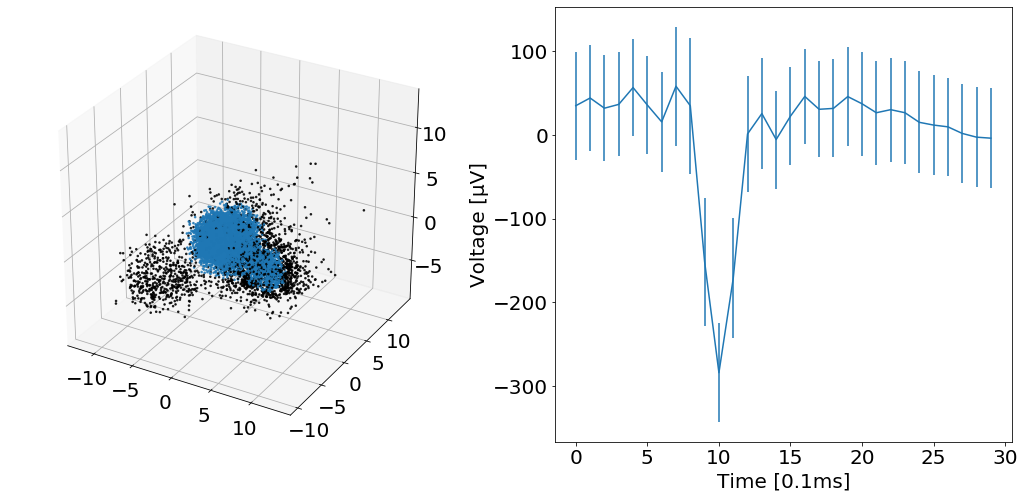

 46%|████▋     | 19/41 [00:46<00:58,  2.67s/it]



ELECTRODE:  b'32'
Total spikes 16293

Spike detected as noise 2306

Number of clusters:  2 
The silhouette score is: 0.544724558801795

Blue spikes: 13927

Orange spikes: 60


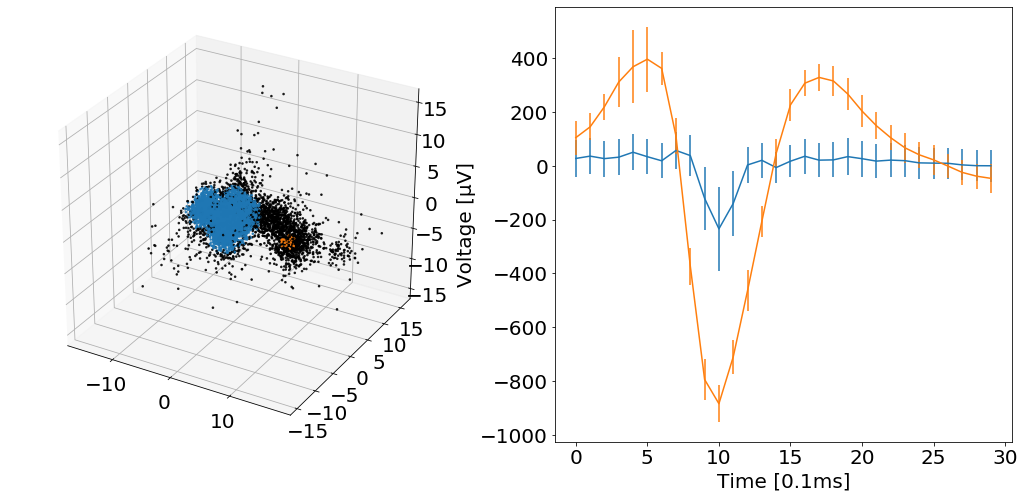

 49%|████▉     | 20/41 [00:52<01:12,  3.46s/it]



ELECTRODE:  b'53'
Total spikes 17309

Spike detected as noise 1584

Only one cluster detected

Blue spikes: 15725


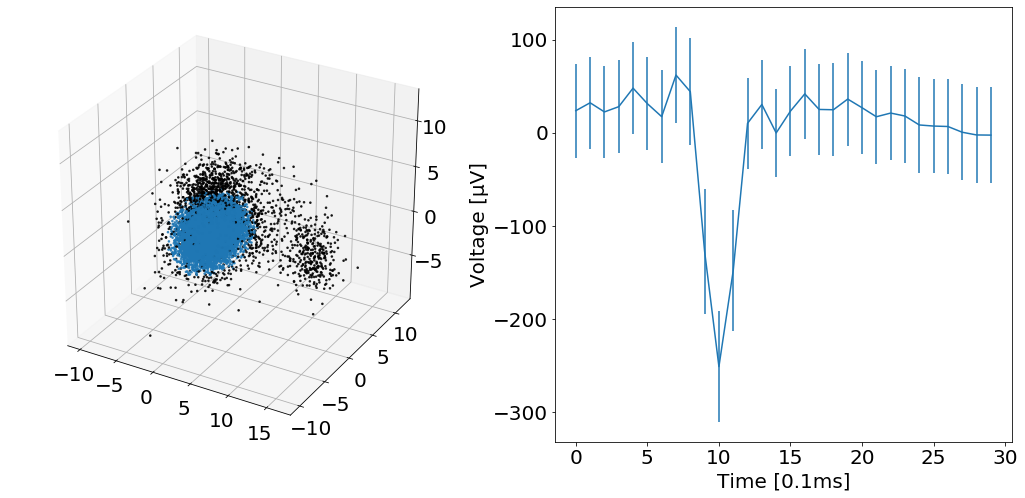

 51%|█████     | 21/41 [00:53<00:57,  2.88s/it]



ELECTRODE:  b'71'
Total spikes 20386

Spike detected as noise 1279

Number of clusters:  2 
The silhouette score is: 0.49070075323861784

Blue spikes: 17994

Orange spikes: 1113


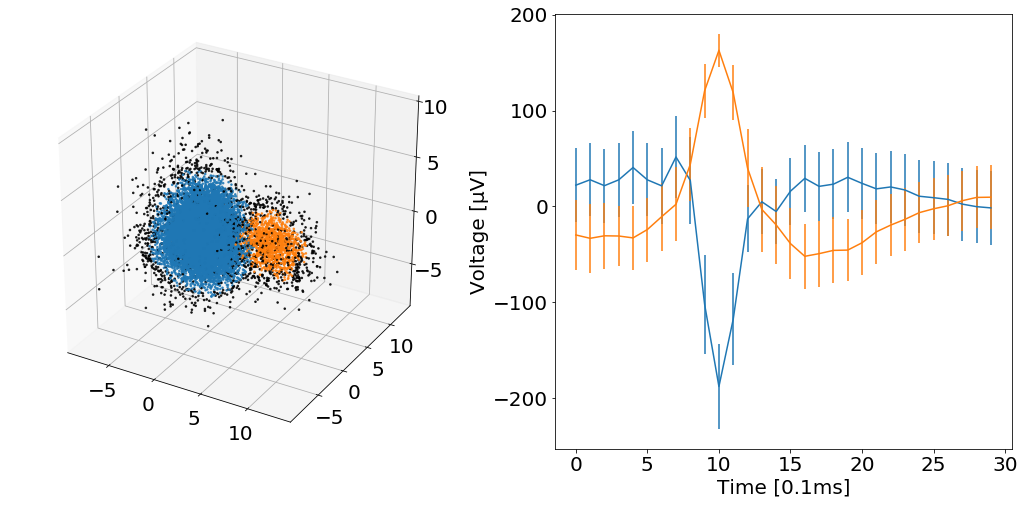

 54%|█████▎    | 22/41 [01:00<01:16,  4.05s/it]



ELECTRODE:  b'63'
Total spikes 17465

Spike detected as noise 1801

Only one cluster detected

Blue spikes: 15664


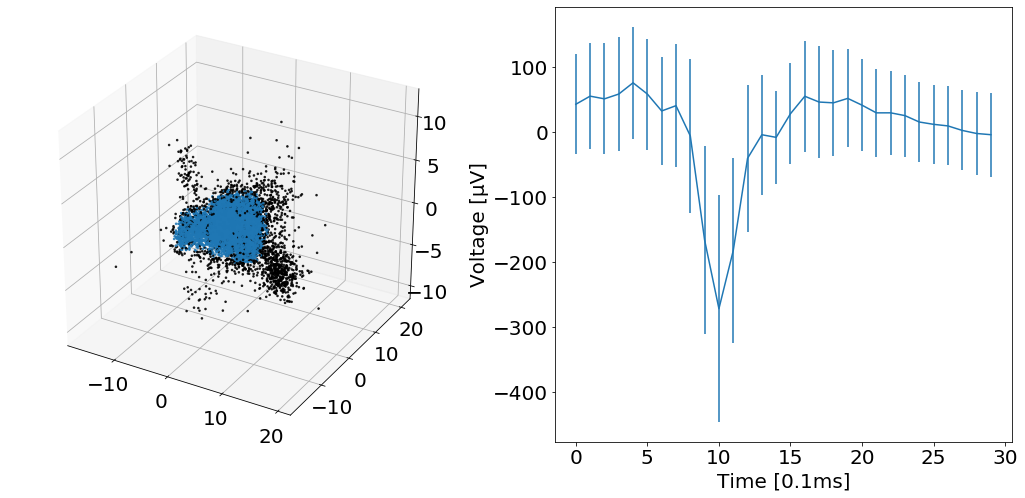

 56%|█████▌    | 23/41 [01:01<00:58,  3.27s/it]



ELECTRODE:  b'72'
Total spikes 14032

Spike detected as noise 2306

Only one cluster detected

Blue spikes: 11726


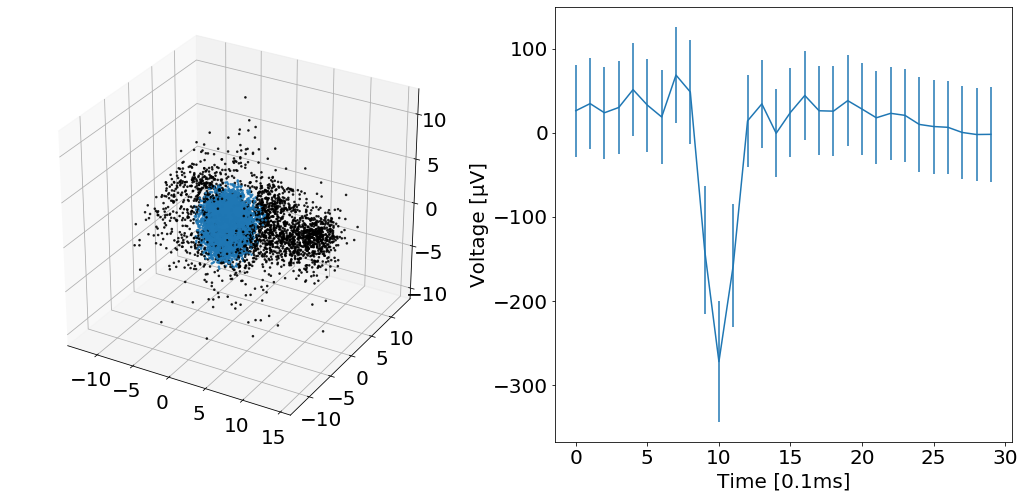

 59%|█████▊    | 24/41 [01:03<00:45,  2.68s/it]



ELECTRODE:  b'82'
Total spikes 19137

Spike detected as noise 1491

Number of clusters:  2 
The silhouette score is: 0.49892177083140404

Blue spikes: 17259

Orange spikes: 387


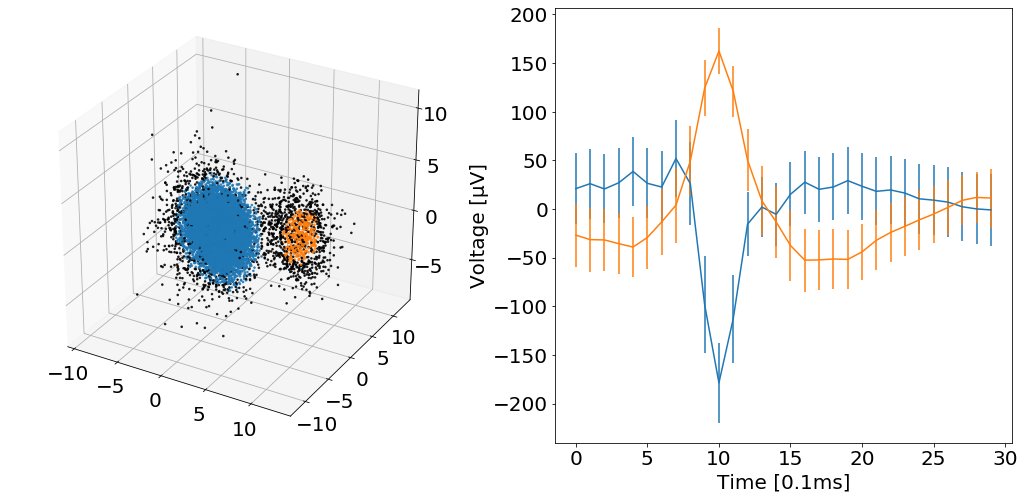

 61%|██████    | 25/41 [01:09<01:00,  3.78s/it]



ELECTRODE:  b'73'
Total spikes 17035

Spike detected as noise 1039

Only one cluster detected

Blue spikes: 15996


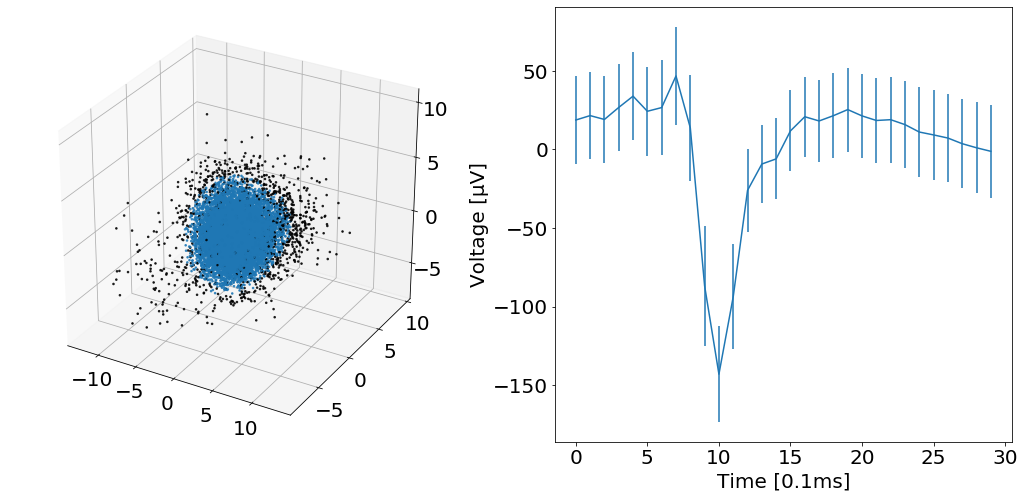

 63%|██████▎   | 26/41 [01:10<00:45,  3.05s/it]



ELECTRODE:  b'83'
Total spikes 11171

Spike detected as noise 747

Only one cluster detected

Blue spikes: 10424


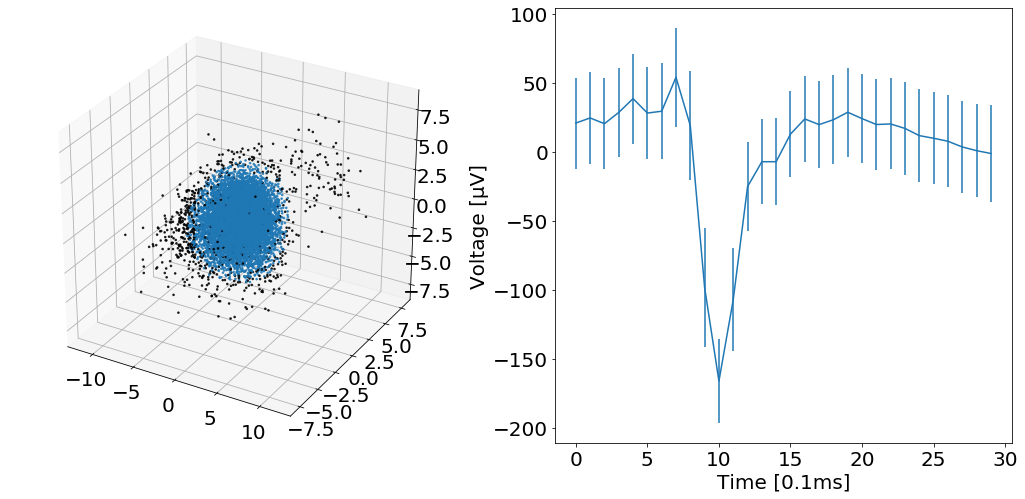

 66%|██████▌   | 27/41 [01:11<00:33,  2.42s/it]



ELECTRODE:  b'64'
Total spikes 13064

Spike detected as noise 850

Only one cluster detected

Blue spikes: 12214


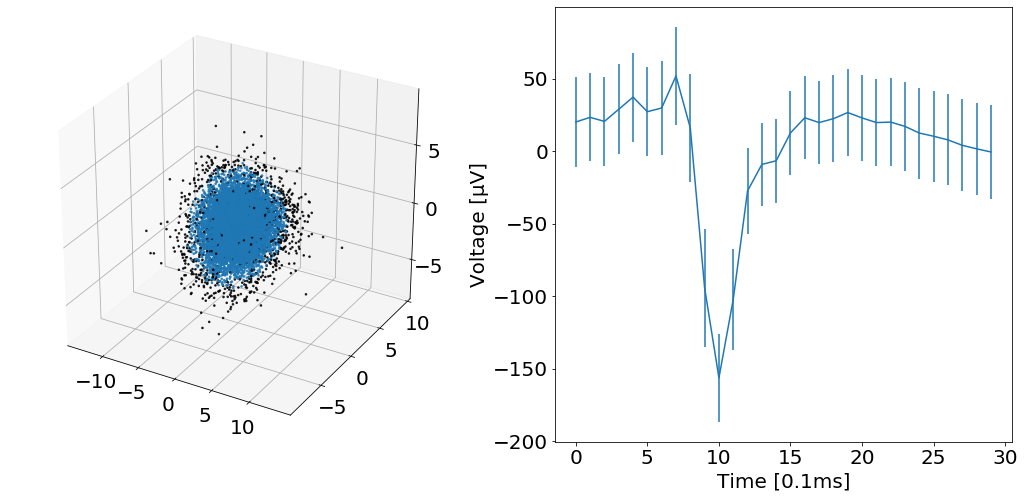

 68%|██████▊   | 28/41 [01:12<00:26,  2.05s/it]



ELECTRODE:  b'74'
Total spikes 16644

Spike detected as noise 1067

Only one cluster detected

Blue spikes: 15577


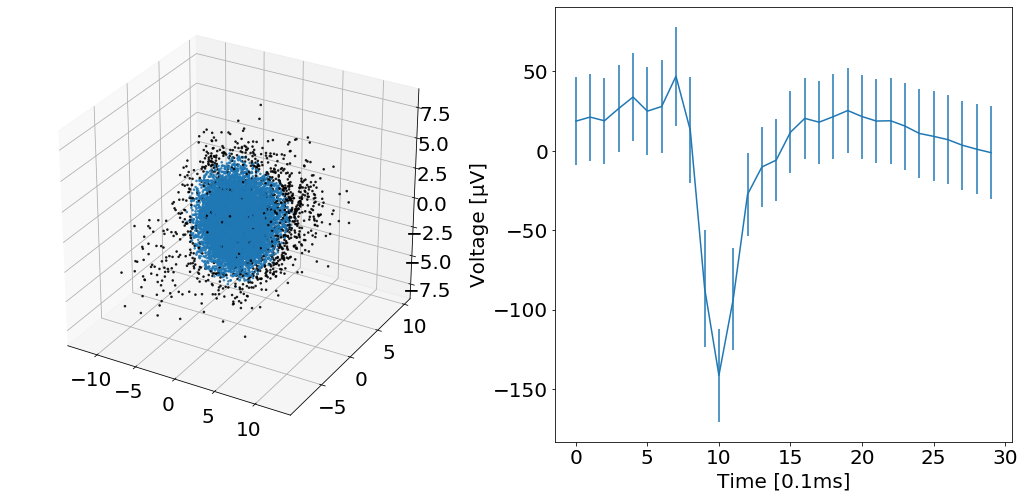

 71%|███████   | 29/41 [01:14<00:22,  1.86s/it]



ELECTRODE:  b'84'
Total spikes 12876

Spike detected as noise 911

Only one cluster detected

Blue spikes: 11965


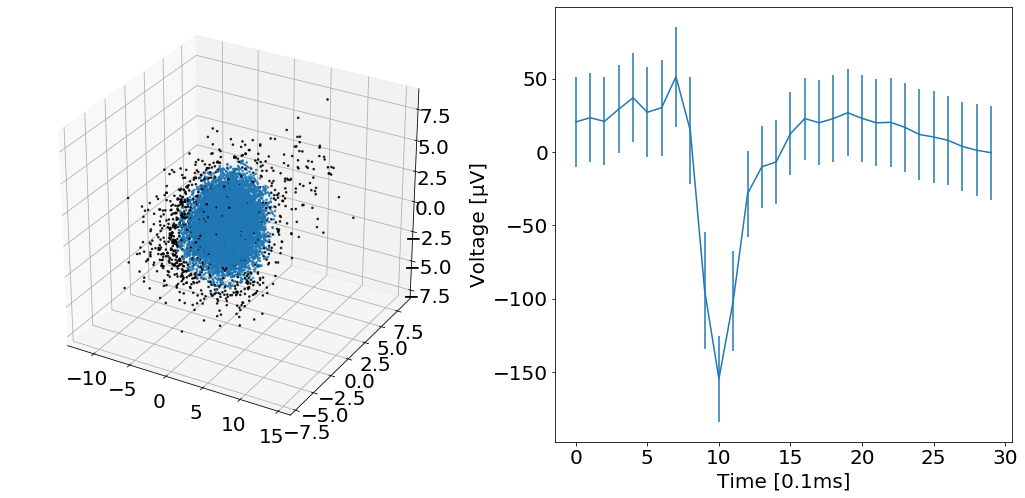

 73%|███████▎  | 30/41 [01:15<00:18,  1.64s/it]



ELECTRODE:  b'85'
Total spikes 14546

Spike detected as noise 996

Only one cluster detected

Blue spikes: 13550


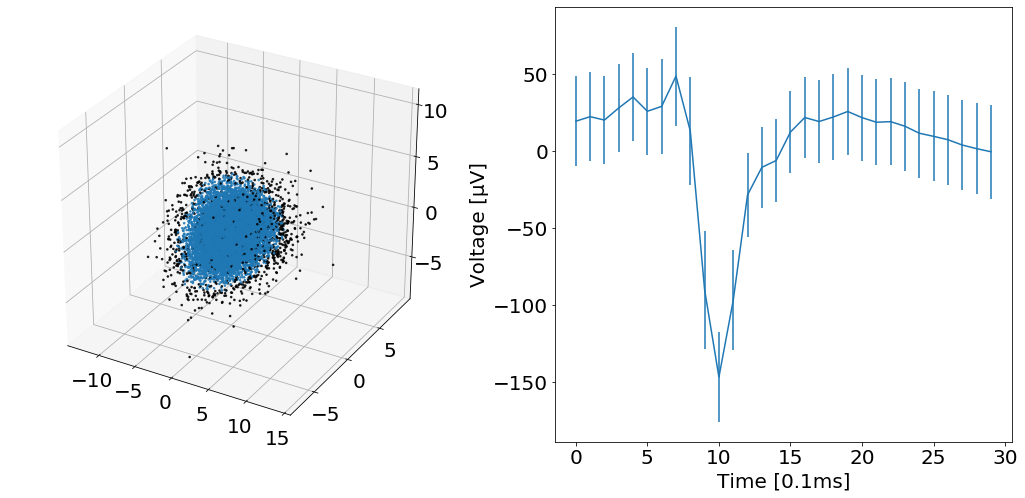

 76%|███████▌  | 31/41 [01:16<00:15,  1.50s/it]



ELECTRODE:  b'75'
Total spikes 21212

Spike detected as noise 1373

Only one cluster detected

Blue spikes: 19839


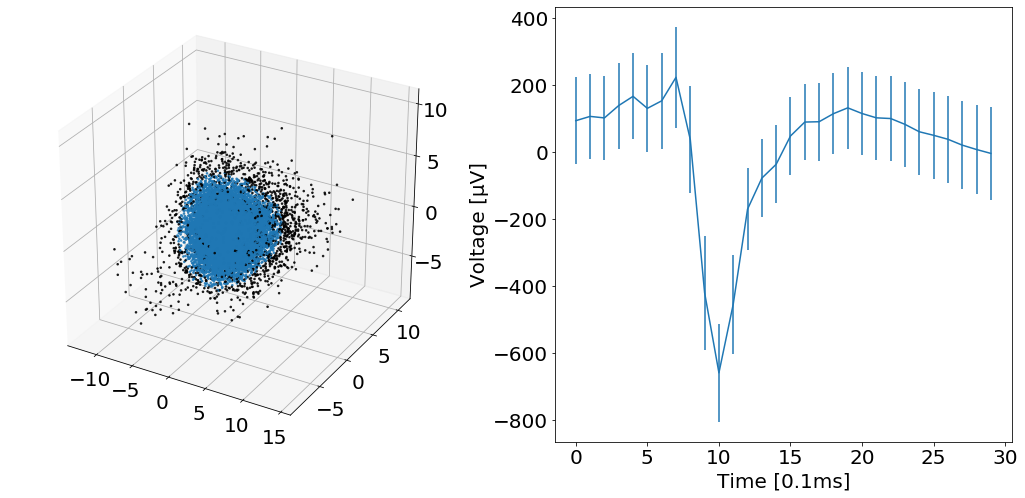

 78%|███████▊  | 32/41 [01:18<00:13,  1.55s/it]



ELECTRODE:  b'65'
Total spikes 14858

Spike detected as noise 975

Only one cluster detected

Blue spikes: 13883


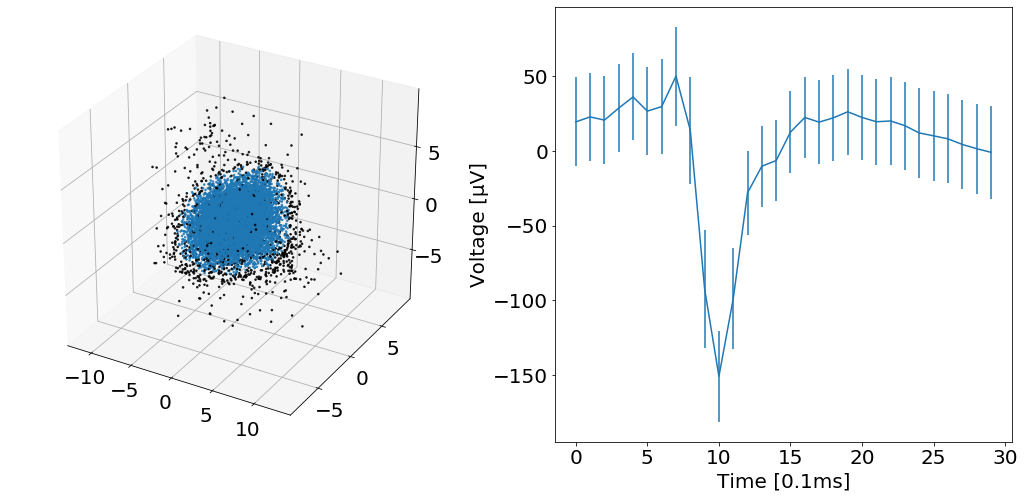

 80%|████████  | 33/41 [01:19<00:11,  1.43s/it]



ELECTRODE:  b'86'
Total spikes 15345

Spike detected as noise 976

Only one cluster detected

Blue spikes: 14369


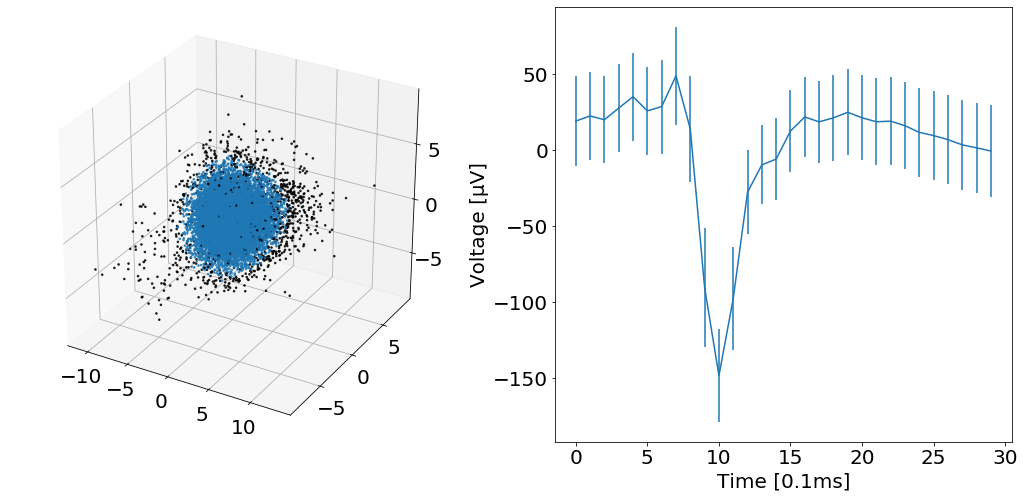

 83%|████████▎ | 34/41 [01:20<00:09,  1.35s/it]



ELECTRODE:  b'76'
Total spikes 17743

Spike detected as noise 1075

Only one cluster detected

Blue spikes: 16668


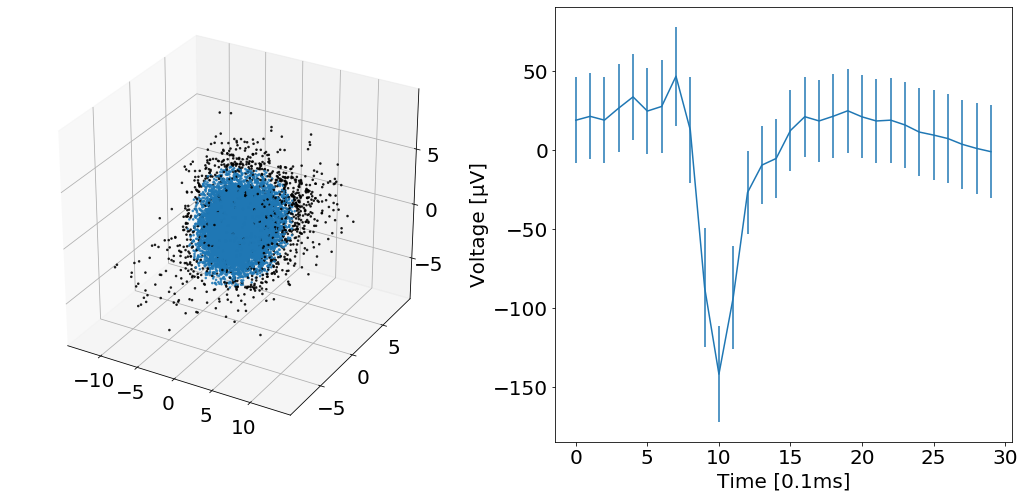

 85%|████████▌ | 35/41 [01:21<00:08,  1.34s/it]



ELECTRODE:  b'87'
Total spikes 16504

Spike detected as noise 983

Only one cluster detected

Blue spikes: 15521


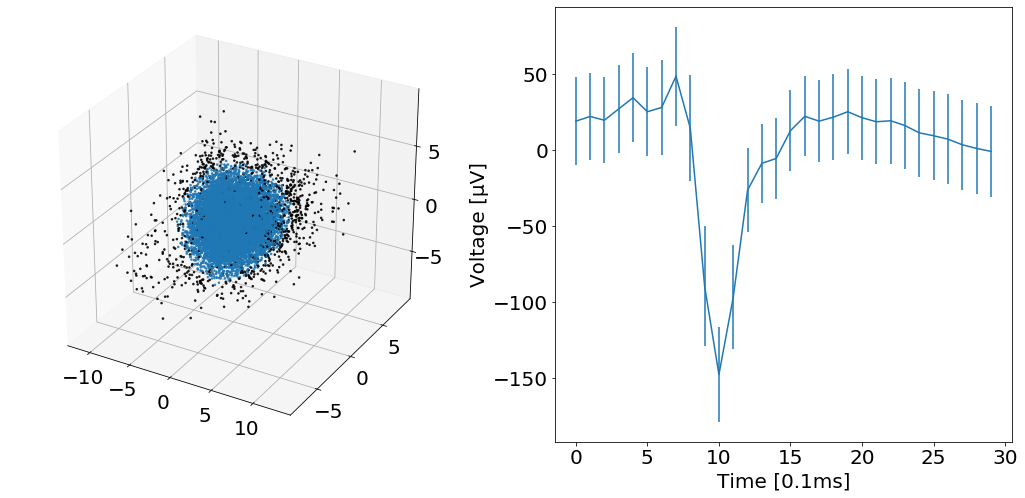

 88%|████████▊ | 36/41 [01:23<00:06,  1.33s/it]



ELECTRODE:  b'77'
Total spikes 11962

Spike detected as noise 2112

Number of clusters:  4 
The silhouette score is: 0.3672469949717265

Blue spikes: 8928

Orange spikes: 715

Green spikes: 147

Red spikes: 60


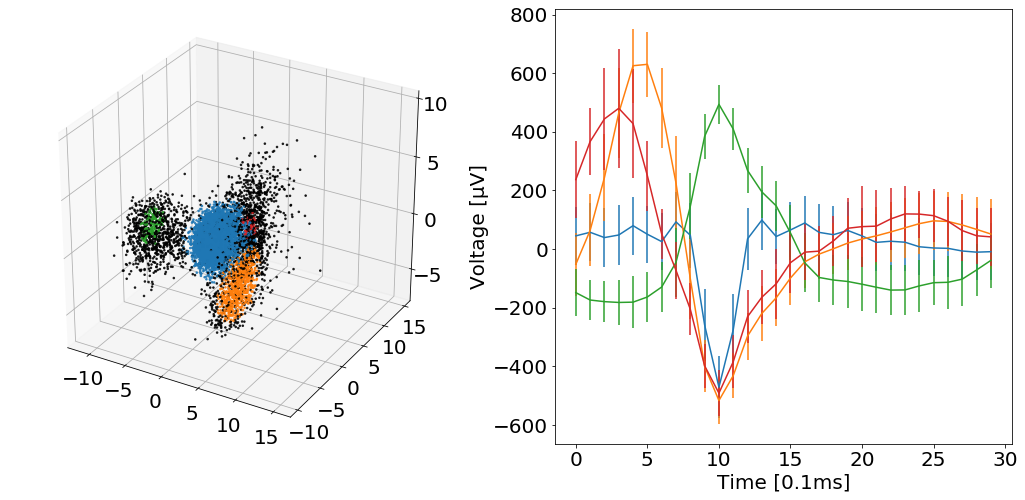

 90%|█████████ | 37/41 [01:26<00:07,  1.81s/it]



ELECTRODE:  b'66'
Total spikes 16212

Spike detected as noise 1271

Number of clusters:  2 
The silhouette score is: 0.4961898970593762

Blue spikes: 13753

Orange spikes: 1188


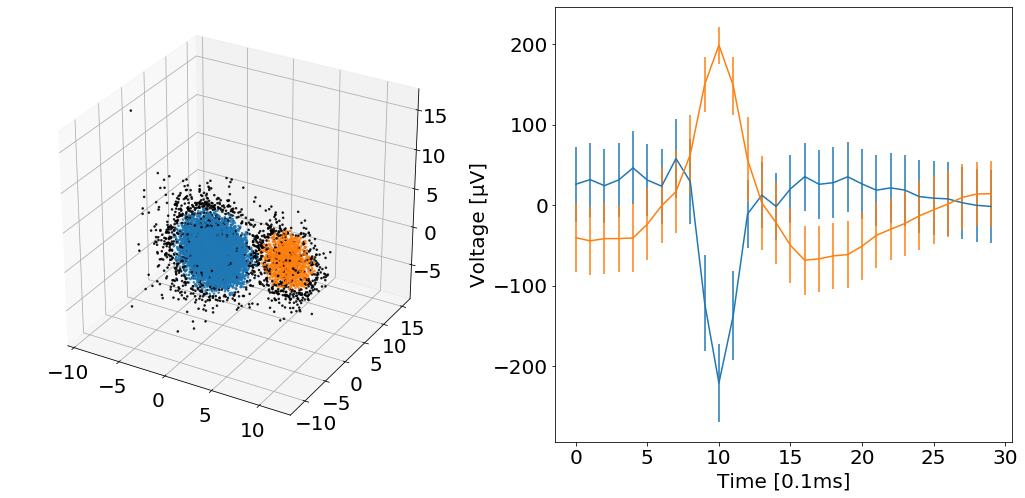

 93%|█████████▎| 38/41 [01:30<00:08,  2.70s/it]



ELECTRODE:  b'78'
Total spikes 26419

Spike detected as noise 1034

Only one cluster detected

Blue spikes: 25385


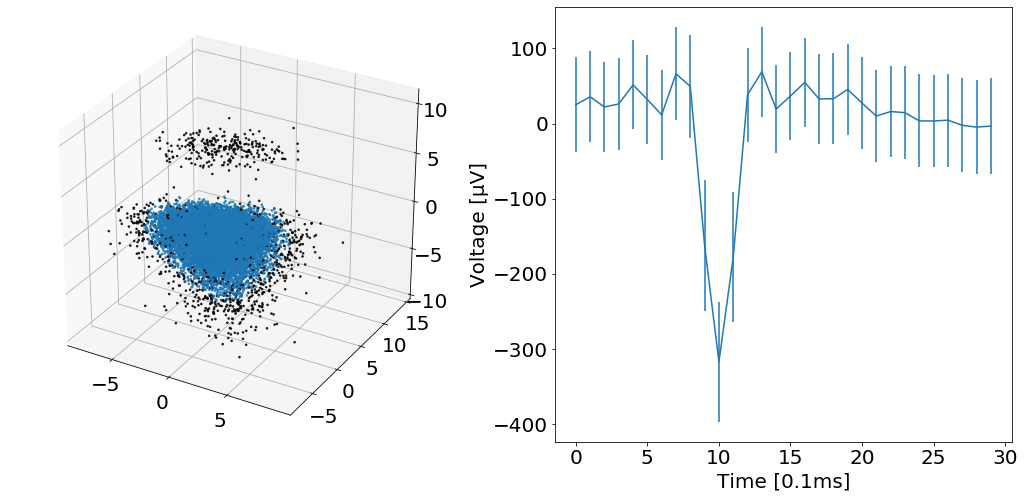

 95%|█████████▌| 39/41 [01:33<00:05,  2.59s/it]



ELECTRODE:  b'67'
Total spikes 15183

Spike detected as noise 2129

Only one cluster detected

Blue spikes: 13054


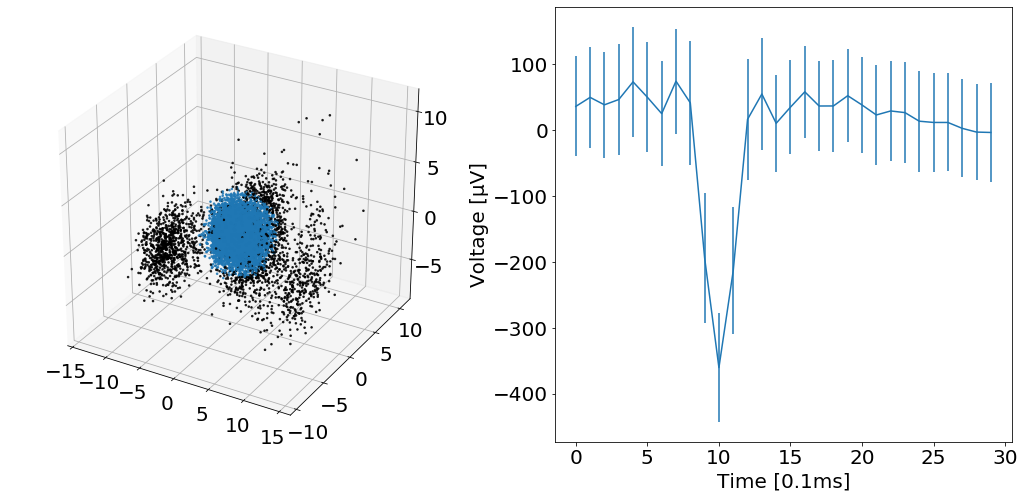

 98%|█████████▊| 40/41 [01:34<00:02,  2.23s/it]



ELECTRODE:  b'57'
Total spikes 15507

Spike detected as noise 1335

Only one cluster detected

Blue spikes: 14172


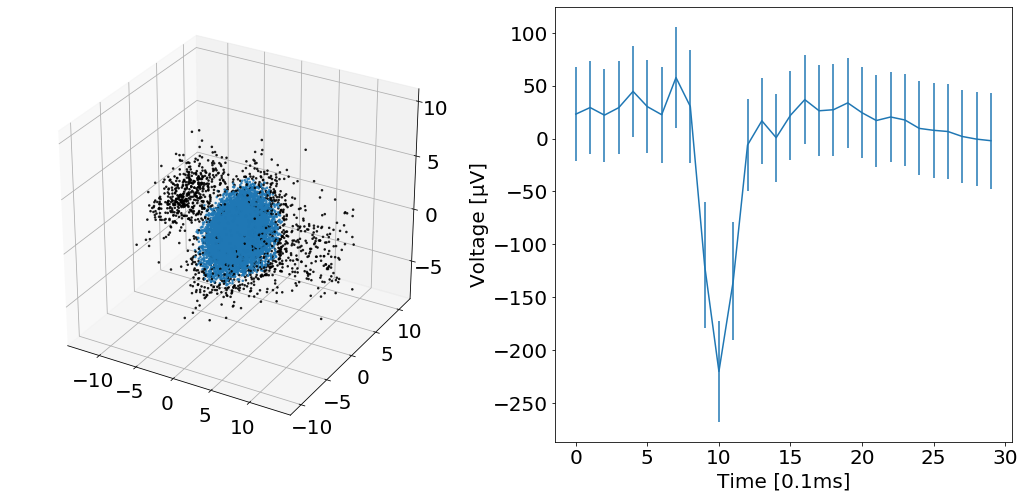

100%|██████████| 41/41 [01:35<00:00,  2.34s/it]


In [127]:
#DBSCAN CLUSTERING
cluster = []
for electrode in tqdm(filtered_readings.columns):
    print("\n\nELECTRODE: ",electrode)
    cluster.append(perform_pca_DBSCAN(extracted[legend[electrode].values[0]],np.array(aligned_indexes[legend[electrode].values[0]]),fs = fs,n_comp=3, distanza = 1.1, punti_min = 60))

In [128]:
#K-MEANS CLUSTERING
#cluster = []
#for electrode in tqdm(filtered_readings.columns):
#    print("\n\nELECTRODE: ",electrode)
#    cluster.append(perform_pca_kmeans(extracted[legend[electrode].values[0]],np.array(aligned_indexes[legend[electrode].values[0]]),fs = fs,n_comp=3, centroids=False))

In [129]:
#HIERARCHICAL CLUSTERING
#cluster = []
#for electrode in tqdm(filtered_readings.columns):
#    print("\n\nELECTRODE: ",electrode)
#    cluster.append(perform_pca_gerarchico(extracted[legend[electrode].values[0]],np.array(aligned_indexes[legend[electrode].values[0]]),fs = fs,n_comp=3, centroids=False))

In [130]:
for clu in cluster:
    print(len(clu))

2
3
3
2
3
5
2
2
2
2
2
2
2
2
2
2
3
3
2
3
2
3
2
2
3
2
2
2
2
2
2
2
2
2
2
2
5
3
2
2
2


In [131]:
neurons = []
for electrode in cluster:
    for neuron in electrode:
        neurons.append(neuron)

In [132]:
len(neurons)

97

In [133]:
adj_neur=[]

counter = 0
max_len=0

for neu in neurons:
    print('counter: ',counter,neu.shape[0])
    if neu.shape[0]>max_len:
        max_len=neu.shape[0]
    counter+=1
for neuron in neurons:
    if neuron.shape[0]<max_len:
        diff = max_len-neuron.shape[0]
        adj_neur.append(np.concatenate((neuron,np.zeros([diff]))))
    

counter:  0 1170
counter:  1 26826
counter:  2 2111
counter:  3 13965
counter:  4 594
counter:  5 1668
counter:  6 12675
counter:  7 181
counter:  8 2283
counter:  9 16452
counter:  10 1336
counter:  11 13386
counter:  12 2131
counter:  13 2116
counter:  14 13859
counter:  15 737
counter:  16 197
counter:  17 65
counter:  18 971
counter:  19 12869
counter:  20 909
counter:  21 11721
counter:  22 836
counter:  23 9940
counter:  24 815
counter:  25 9920
counter:  26 878
counter:  27 8258
counter:  28 812
counter:  29 10233
counter:  30 866
counter:  31 11689
counter:  32 1023
counter:  33 14081
counter:  34 978
counter:  35 13568
counter:  36 951
counter:  37 12037
counter:  38 1243
counter:  39 16775
counter:  40 694
counter:  41 1342
counter:  42 15373
counter:  43 566
counter:  44 1922
counter:  45 12316
counter:  46 2306
counter:  47 13927
counter:  48 60
counter:  49 1584
counter:  50 15725
counter:  51 1279
counter:  52 17994
counter:  53 1113
counter:  54 1801
counter:  55 15664
c

In [134]:
save_data = name_data+'.txt'

In [135]:
np.savetxt(save_data,adj_neur, delimiter=', ', fmt='%12.8f')